# Project 1: Customer Database
**This is the first of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-10-13, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python**
- **For each question you may use as many cells for your solution as you like**
- **You should document your solution and explain the choices you've made (for example by using multiple cells and use Markdown to assist the reader of the notebook)**
- **You should not remove the problem statements, and you should not modify the structure of the notebook**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**
- **You will be assessed according to correctness and readability of your code, choice of solution, choice of tools and libraries, and documentation of your solution**

## Introduction
Your team has been hired by the company X as data scientists. X makes gadgets for a wide range of industrial and commercial clients.

As in-house data scientists, your teams first task, as per request from your new boss, is to optimize business operations. You have decided that a good first step would be to analyze the companys historical sales data to gain a better understanding of where profit is coming from. It may also reveal some low hanging fruit in terms of business opportunities.

To get started, you have called the IT department to get access to the customer and sales transactions database. To your horror you've been told that such a database doens't exist, and the only record of sales transactions is kept by John from finance in an Excel spreadsheet. So you've emailed John asking for a CSV dump of the spreadsheet...

In this project you need to clean the data you got from John, enrich it with further data, prepare a database for the data, and do some data analysis. The project is comprised of five parts. They are intended to be solved in the order they appear, but it is highly recommended that you read through all of them and devise an overall strategy before you start implementing anything.

## Part 1: Cleaning the data
John has emailed you the following link to the CSV dump you requested.

- [transactions.csv](https://raw.githubusercontent.com/patrickcording/02807-comp-tools/master/docker/work/data/transactions.csv)

It seems as though he has been a bit sloppy when keeping the records. 

In this part you should:
- Explain what the data is
- Clean it to prepare it for inserting into a database and doing data analysis 

---
### Solution

# Loading Dataset

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import datetime
from datetime import datetime, time, date

data = pd.read_csv("transactions.csv", sep = ",", parse_dates = {"dates": [5]})
data = data.fillna("Unknown")
data.head(5)

,dates,part,company,country,city,price
0,2016-01-02 00:01:05,54868-5165,Chatterbridge,Spain,Barcelona,784.79€
1,2016-01-02 00:05:26,60505-2867,Lajo,Greece,Thessaloniki,187.99€
2,2016-01-02 00:18:30,24385-268,Flipstorm,Greece,Athens,221.73€
3,2016-01-02 02:32:30,76117-001,Twitterbeat,France,Annecy,1075.82€
4,2016-01-02 04:51:55,44946-1046,Chatterbridge,Spain,Barcelona,412.55€


# Cleaning the prices, company names, countries and cities

In data there are NaN values. We have filled them with "Unknown" to find them easily. We have seen that there are some elements that they only appears a few number of times, so we consider this elements as miswrittings. Some miswriting are pretty self-explanatory like US and United States. But for the others, especially in company names, cities and countries there are some miswritings which can be guessed by the other attributes. For example, Company Chatterbridge is located in Spain and Barcelona. If Barcelona is missing in any rows it is automatically filled with Barcelona. (It is just an example since it is in the 1st row.)
We have assumed that knowing two out of three of company name, country and city gives us freedom to guess other attribute.
So we are looking for the combinations of these three elements which appears pretty often.

In [2]:
combination = set()
for i in range(data.shape[0]):
    try:
        if (data.iloc[i, 2] in num_comp) and (data.iloc[i, 3] in num_countries) and (data.iloc[i, 4] in num_cities) == True:
            combination.add(tuple(data.iloc[i, 2:5]))
    except:
        None

find_combination function returns the combination of the three values that correspond to the row of the miswrtting, so we can correct it

In [3]:
def find_combination(row, combinations):
    res = None
    row = tuple(row)
    for i in combinations:
        cont = 0
        
        for j in range(3):
            if(row[j] == i[j]):
                cont += 1
            
        if cont == 2:
            res = i
    return res   

For the prices there were values like "void", "NaN", "na" and values without currency. We have found these rows and then dropped them. **In order to obtain one type of currency value**, we have parsed price column into "currency", "value" columns. At the enrichment of data we have converted all values into € and then analyzed in that way. Before going into details, we would like to mention about some price values. There are some negative values. We are evaluating this given excel file as an accountant excel. Therefore we say these values are for returned parts. So, we assume If any of parts are returned, those are processed with "-" as negative values.

In [4]:
symbols = ['€', '£', '$', '¥']

def clean_price(price):
    value = []
    symbol = "None"
    for i in price:
        if i in symbols:
            symbol = i
        else:
            value.append(i)
    return "".join(value), symbol

In order to see what values appears just a few times, we count this times in this section of the code and we just save the ones which appears more than 10 times.

In [5]:
num_comp = data.groupby(["company"])["company"].count()
num_countries = data.groupby(["country"])["country"].count()
num_cities = data.groupby(["city"])["city"].count()

num_comp = num_comp[num_comp > 10]
num_countries = num_countries[num_countries > 10]
num_cities = num_cities[num_cities > 10]

num_countries = num_countries.drop(["Unknown"])
num_cities = num_cities.drop(["Unknown"])

In this loop we go row by row, we see if there is some of rows values are not common or NaN and we guess the other one then we clean the values.

In [6]:
remove = [] 
index_list = []
for i in range(data.shape[0]):
    
    if not((data.iloc[i, 2] in num_comp) and (data.iloc[i, 3] in num_countries) and (data.iloc[i, 4] in num_cities)):
        if(find_combination(data.iloc[i, 2:5], combination) == None):
            remove.append(i)
        data.iloc[i, 2:5] = find_combination(data.iloc[i, 2:5], combination)

    
    data.loc[i, "value"], data.loc[i, "currency"] = clean_price(data.loc[i, "price"])
    
    try:
        datetime.strptime(data["dates"][i], '%Y-%m-%d %H:%M:%S')
    
    except ValueError:
        index_list.append(i)

# Cleaning the dates

To fix dates, we first found out the rows which are problematic in terms of not fitting the datetime type of '%Y-%m-%d %H:%M:%S'. And then with the functions below, we have found a way to turn them into datetime object. There were 2 values as 32th day of 6th month. We have assumed these as typo and then fixed them as 30th day of 6th month. Then, to insert these rows back into data we had to add information of hours, minutes and seconds. Since we assume, hours information isn't so much important in our case, we have created dummy hours, minutes and seconds. Then plugged them back according to their index value.


In [7]:
problematic_rows = data.iloc[index_list]

In [8]:
def dateForSlash(x):
    try:
        return datetime.strptime(x, '%d/%m/%Y')
    except:
        return x
    
def dateForDash(x):
    try:
        return datetime.strptime(x, '%Y-%m-%d')
    except:
        return x
    
def dateForDashSp(x):
    try:
        return datetime.strptime(x, '%Y-%m-%d ')
    except:
        return x
    
def add_secs_to_time(dates):
    tm = time(1, 1, 1)
    dates = dates.combine(dates, tm)
    return dates

In [9]:
# 32-6-2016 problem
problematic_rows.at[3539, "dates"] = "2016-06-30"
problematic_rows.at[3540, "dates"] = "2016-06-30"

# Same format
problematic_rows["dates"] = problematic_rows["dates"].apply(lambda x: dateForSlash(x))
problematic_rows["dates"]=problematic_rows["dates"].apply(lambda x: dateForDash(x))
problematic_rows["dates"]=problematic_rows["dates"].apply(lambda x: dateForDashSp(x))

# Adding hours minutes and seconds
problematic_rows["dates"]=problematic_rows["dates"].apply(lambda x: add_secs_to_time(x))

# Replacing problematic rows for fixed rows
data.iloc[index_list, :] = problematic_rows 

In [10]:
# Replacing date column for day column and time column

data["dates"] = pd.to_datetime(data["dates"])
data['day'] = data['dates'].dt.date
data['time'] = data['dates'].dt.time

data = data.drop(["dates"], axis = 1)
data = data.drop(remove).reset_index().drop("index", axis = 1)
dont_remove = data["currency"] != "None"
data = data.drop("price", axis = 1).loc[dont_remove].reset_index().drop("index", axis = 1)

data.head(5)

,part,company,country,city,value,currency,day,time
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79,€,2016-01-02,00:01:05
1,60505-2867,Lajo,Greece,Thessaloniki,187.99,€,2016-01-02,00:05:26
2,24385-268,Flipstorm,Greece,Athens,221.73,€,2016-01-02,00:18:30
3,76117-001,Twitterbeat,France,Annecy,1075.82,€,2016-01-02,02:32:30
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55,€,2016-01-02,04:51:55


---
## Part 2: Enriching the data

A common task for a data scientists is to combine or enrich data from internal sources with data available from external sources. The purpose of this can be either to fix issues with the data or to make it easier to derive insights from the data.

In this part you should enrich your data with data from at least one external source. You may look to part 4 for some  inspiration as to what is required. Your solution should be automated, i.e., you can not ask the reader of your notebook to download any data manually. You should argue why and what you expect to achieve by the enrichments you are doing.

---
### Solution

As it is mentioned above, very first act of enrichment is downloading data using exchagerate api in order to find out exact value of each transaction in terms of Euro. In that way "eur_value" column is created. 
There are other enrichments regarding the countries economic indicators. Understanding the economic trends of a country is important for our company to forecast further transactions.

In [11]:
import requests

params = {"symbols": "USD,GBP,CNY",
          "start_at": min(data["day"]),
          "end_at": max(data["day"])
         }
req = requests.get('https://api.exchangeratesapi.io/history?', params=params)
json_exchange = req.json()
rates = json_exchange["rates"]

rates = pd.DataFrame(rates)
rates = rates.T
rates["EUR"] = 1.0

rates["date"] = rates.index
rates["date"] = pd.to_datetime(rates["date"]).dt.date
rates.sort_values(by=['date'], inplace=True, ascending=True)
rates = rates.reset_index(drop = True)


rates.head(5)

,CNY,GBP,USD,EUR,date
0,7.1208,0.73810,1.0898,1.0,2016-01-04
1,7.0074,0.73235,1.0746,1.0,2016-01-05
2,7.0388,0.73440,1.0742,1.0,2016-01-06
3,7.1672,0.74545,1.0868,1.0,2016-01-07
4,7.1577,0.74519,1.0861,1.0,2016-01-08


In [12]:
dict_currency = {
    '¥' : "CNY",
    '$' : "USD", 
    '£' : "GBP",
    '€' : "EUR"}

In [13]:
def convert_value(rates, row, dic, date):
    return float(row["value"]) / float(rates.loc[rates["date"] == date, :][dic[row["currency"]]])

In [14]:
dates = set(rates["date"])
tmp = rates.sort_values("date").loc[0, "date"]

for i in range(data.shape[0]):
    if data.loc[i, "day"] in dates:
        tmp = data.loc[i, "day"]
    data.loc[i, "eur_value"] = convert_value(rates, data.iloc[i, :], dict_currency, tmp)

In [15]:
data.iloc[1200:1220, :]

,part,company,country,city,value,currency,day,time,eur_value
1200,17156-617,Chatterbridge,Spain,Barcelona,1439.98,€,2016-02-21,09:43:59,1439.980000
1201,52959-433,Buzzbean,Germany,Düsseldorf,335.96,€,2016-02-21,10:13:38,335.960000
1202,52125-444,Thoughtmix,Portugal,Amadora\t,296.68,€,2016-02-21,10:40:05,296.680000
1203,59779-601,Yozio,Greece,Patras,157.41,€,2016-02-21,11:19:28,157.410000
1204,62011-0219,Buzzbean,Germany,Düsseldorf,806.97,€,2016-02-21,11:27:00,806.970000
1205,49349-471,Roodel,Portugal,Aranhas,817.25,€,2016-02-21,13:07:43,817.250000
1206,0603-6134,Voomm,France,Paris,803.02,€,2016-02-21,14:20:20,803.020000
1207,0615-7679,Thoughtmix,Portugal,Amadora\t,476.6,€,2016-02-21,15:13:14,476.600000
1208,49349-106,Yozio,Greece,Patras,958.43,€,2016-02-21,18:10:08,958.430000
1209,0228-2167,Zoonder,United States,Boston,885.45,$,2016-02-21,18:33:26,797.990267


https://data.worldbank.org/indicator/ is the link at where we have retrieved our data. Since there isn't api, we have downloaded and then will supply these excel.csv files with the ipython file.

In [16]:
GDP_Per_Capita = pd.read_csv("Data_1_GDP_Per_Capita.csv")
Government_Debts = pd.read_csv("Data_2_Government_Debts.csv")
Industry = pd.read_csv("Data_3_Industry.csv")
Inflation = pd.read_csv("Data_4_Inflation.csv")
Manufacturing = pd.read_csv("Data_5_Manufacturing.csv")
Population = pd.read_csv("Data_6_Population.csv")
Unemployment_Rate = pd.read_csv("Data_7_Unemployment_Rate.csv")

In [17]:
GDP_Per_Capita.columns = ["C_Name", "Indicator", "GDP_2016", "GDP_2017", "GDP_2018"]
GDP_Per_Capita.head(3)

,C_Name,Indicator,GDP_2016,GDP_2017,GDP_2018
0,Afghanistan,GDP per capita (current US$),547.228110,556.302138,520.896603
1,Angola,GDP per capita (current US$),3506.072885,4095.812942,3432.385736
2,Albania,GDP per capita (current US$),4124.108543,4532.889198,5253.630064


In [18]:
Government_Debts.head(3)

,Country Name,Indicator Name,2011,2012,2013,2014,2015,2016
0,Albania,"Central government debt, total (current LCU)","905,724,300,000.00","848,589,470,000.00","952,877,800,000.00","1,023,040,800,000.00","1,145,500,940,000.00","1,188,814,490,000.00"
1,United Arab Emirates,"Central government debt, total (current LCU)",NaN,NaN,"27,127,927,216.00",NaN,NaN,NaN
2,Australia,"Central government debt, total (current LCU)","433,300,000,000.00","598,400,000,000.00","584,400,000,000.00","674,700,000,000.00","762,718,000,000.00","907,555,000,000.00"


In [19]:
Industry.head(3)

,Country Name,Indicator Name,2016,2017,2018
0,Afghanistan,"Industry (including construction), value added...","4,225,552,557.80","4,467,967,033.70",NaN
1,Angola,"Industry (including construction), value added...","43,122,816,968.97","51,497,116,403.48",NaN
2,Albania,"Industry (including construction), value added...","2,507,727,106.86","2,653,872,008.07","3,208,067,380.81"


In [20]:
Inflation.head(3)

,Country Name,Indicator Name,2016,2017,2018
0,Aruba,"Inflation, consumer prices (annual %)",-0.9%,-0.5%,3.6%
1,Angola,"Inflation, consumer prices (annual %)",32.4%,31.7%,20.2%
2,Albania,"Inflation, consumer prices (annual %)",1.3%,2.0%,2.0%


In [21]:
Manufacturing.head(3)
Manufacturing.columns = ["C_Name", "Indicator", "2016_Manufac", "2017_Manufac", "2018_Manufac"]

In [22]:
Manufacturing.head(3)

,C_Name,Indicator,2016_Manufac,2017_Manufac,2018_Manufac
0,Albania,"Manufacturing, value added (current LCU)","83,702,000,000.00","95,290,000,000.00","100,423,190,000.00"
1,United Arab Emirates,"Manufacturing, value added (current LCU)","117,808,000,000.00","123,422,000,000.00","135,617,000,000.00"
2,Argentina,"Manufacturing, value added (current LCU)","1,109,816,297,900.00","1,368,136,774,100.00","1,857,585,888,400.00"


In [23]:
Population.head(3)

,Country Name,Indicator Name,2016,2017,2018
0,Aruba,"Population, total","104,872","105,366","105,845"
1,Afghanistan,"Population, total","35,383,128","36,296,400","37,172,386"
2,Angola,"Population, total","28,842,484","29,816,748","30,809,762"


In [24]:
Unemployment_Rate.head(3)

,Country Name,Indicator Name,2016,2017,2018
0,Albania,"Unemployment, total (% of total labor force) (...",15.2%,13.8%,12.3%
1,United Arab Emirates,"Unemployment, total (% of total labor force) (...",1.6%,2.5%,2.2%
2,Argentina,"Unemployment, total (% of total labor force) (...",NaN,8.3%,9.2%


---
## Part 3: Creating a database
Storing data in a relational database has the advantages that it is persistent, fast to query, and it will be easier access for other employees at Weyland-Yutani.

In this part you should:
- Create a database and table(s) for the data
- Insert data into the tables

You may use SQLite locally to do this. You should argue why you choose to store your data the way you do. 

---
### Solution

Since we have the table in pandas, it is pretty easy to store them in data base. We have creates a database called as "Transactions_Project" which has whole data table in it. To check if they are correctly working or not, we have implemented some queries. The way we are storing our data is very handy and suitable for every query.

In [25]:
import sqlite3
import pandas as pd
conn = sqlite3.connect("Transactions_Project.sqlite")
c = conn.cursor()

In [26]:
data.to_sql(name='transactions', con=conn, if_exists='replace')
conn.commit()
rates.to_sql(name='ExchangeRates', con=conn, if_exists='replace')
conn.commit()
GDP_Per_Capita.to_sql(name='GDP_Per_Capita', con=conn, if_exists='replace')
conn.commit()
Government_Debts.to_sql(name='Government_Debts', con=conn, if_exists='replace')
conn.commit()
Industry.to_sql(name='Industry', con=conn, if_exists='replace')
conn.commit()
Inflation.to_sql(name='Inflation', con=conn, if_exists='replace')
conn.commit()
Manufacturing.to_sql(name='Manufacturing', con=conn, if_exists='replace')
conn.commit()
Population.to_sql(name='Population', con=conn, if_exists='replace')
conn.commit()
Unemployment_Rate.to_sql(name='Unemployment_Rate', con=conn, if_exists='replace')
conn.commit()

C:\Users\han\Anaconda3\lib\site-packages\pandas\core\generic.py:2531: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype, method=method)


---
## Part 4: Analyzing the data
You are now ready to analyze the data. Your goal is to gain some actionable business insights to present to your boss. 

In this part, you should ask some questions and try to answer them based on the data. You should write SQL queries to retrieve the data. For each question, you should state why it is relevant and what you expect to find.

To get you started, you should prepare answers to the following questions. You should add more questions.
#### Who are the most profitable clients?
Knowing which clients that generate the most revenue for the company will assist your boss in distributing customer service ressources.

#### Are there any clients for which profit is declining?
Declining profit from a specific client may indicate that the client is disatisfied with the product. Gaining a new client is often much more work than retaining one. Early warnings about declining profit may help your boss fighting customer churn.


Remember, you are taking this to your new boss, so think about how you present the data.

---
### Solution

- Who are the most profitable clients?

For this question, first we have retrieved data from our database and then created a dataframe which will enable us to create our graph to visualize better.

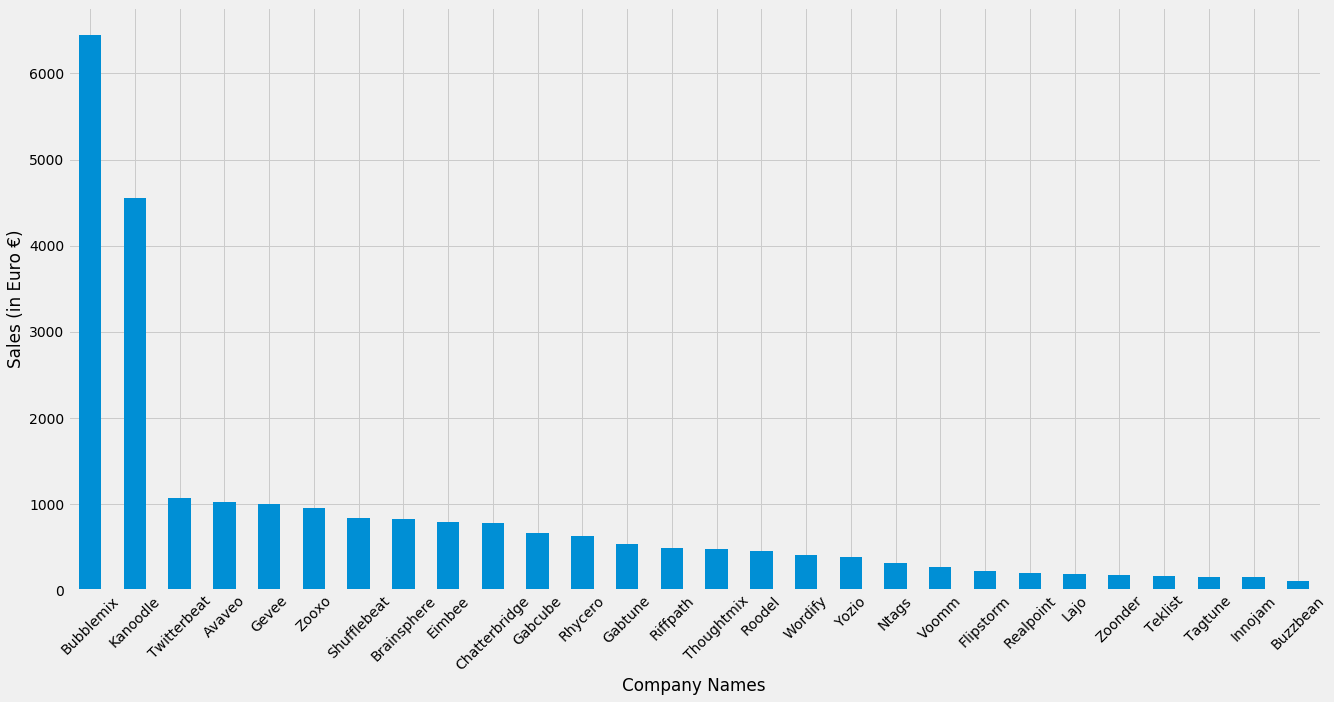

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.ticker import NullFormatter
from matplotlib import style
style.use("fivethirtyeight")

query_1 = "SELECT eur_value, company FROM transactions GROUP BY company ORDER BY eur_value;"
c.execute(query_1)
eur_values_1 = []
companies_1 = []
for eur, company in c.fetchall():
    eur_values_1.append(eur)
    companies_1.append(company)
df_1 = pd.DataFrame()
df_1["eur_values"] = eur_values_1
df_1["companies"] = companies_1

plt.rcParams['figure.figsize'] = [20, 10]
df_1.groupby('companies')['eur_values'].sum().sort_values(ascending=False).plot.bar(y='eur_values', rot=45)
plt.xlabel("Company Names")
plt.ylabel("Sales (in Euro €)")
plt.show()

Especially, Bubblemix and Kanoodle are the most profitable companies we are working with.

- Are there any clients for which profit is declining?

To find out profit declining companies, since graph of all entries is being so difficult to examine visually, we have created a plot for each company. First we retrieved data from database, then created a new dataframe. Then to find the exact euro values of each company at exact date, we have created a new dataframe called as "df_2_1". At this dataframe every company is at a different column, so that it is better to plot and visualize in that way.

In [29]:
query_2 = "SELECT eur_value, company, day FROM transactions GROUP BY day, company ORDER BY company, day;"
c.execute(query_2)

dates_2 = []
eur_values_2 = []
companies_2 = []
for eur, company, date in c.fetchall():
    eur_values_2.append(eur)
    companies_2.append(company)
    dates_2.append(date)
df_2 = pd.DataFrame()
df_2["dates"] = dates_2
df_2["eur_values"] = eur_values_2
df_2["companies"] = companies_2
df_2["dates"] = pd.to_datetime(df_2["dates"])
df_2["dates"] = df_2["dates"].apply(lambda x: x.date())

comp = list(set(df_2["companies"]))
dates = list(set(df_2["dates"]))
resul = np.zeros((len(set(df_2["dates"])), len(set(df_2["companies"]))))

for i in range(len(dates)):
    for j in range(len(comp)):
            tmp = df_2.loc[df_2["companies"] == comp[j], :]
            try:
                tmp = tmp.loc[tmp["dates"] == dates[i], :]
                resul[i, j] = tmp["eur_values"]
            except:
                pass

In [30]:
df_2_1 = pd.DataFrame(resul, index = dates, columns = comp)
df_2_1.head(5)

,Twitterbeat,Gabtune,Zoonder,Voomm,Lajo,Roodel,Realpoint,Rhycero,Brainsphere,Tagtune,...,Innojam,Wordify,Yozio,Bubblemix,Kanoodle,Flipstorm,Thoughtmix,Gevee,Buzzbean,Chatterbridge
2016-02-12,455.00,0.0,720.283814,893.94,0.0,0.00,0.0,0.00,579.38,0.0,...,0.0,439.033259,813.34,6446.081712,0.0,882.8,243.22,0.0,595.56,1071.56
2017-06-16,246.89,0.0,0.000000,0.00,0.0,0.00,0.0,0.00,800.71,0.0,...,0.0,0.000000,165.46,0.000000,0.0,0.0,556.06,0.0,208.45,0.00
2018-10-09,651.21,0.0,0.000000,0.00,0.0,0.00,0.0,0.00,348.16,0.0,...,0.0,115.163970,0.00,0.000000,0.0,0.0,255.10,0.0,129.88,783.85
2018-09-07,281.46,0.0,0.000000,0.00,0.0,744.97,0.0,0.00,159.77,0.0,...,0.0,118.174774,443.69,0.000000,0.0,0.0,786.81,0.0,0.00,640.87
2017-02-28,846.12,0.0,0.000000,0.00,324.8,0.00,0.0,452.22,0.00,0.0,...,0.0,613.532132,0.00,0.000000,0.0,0.0,268.80,0.0,935.78,0.00


In [31]:
df_2_1["dates"] = df_2_1.index
df_2_1["dates"] = pd.to_datetime(df_2_1["dates"]).dt.date
df_2_1.sort_values(by=['dates'], inplace=True, ascending=True)
df_2_1 = df_2_1.reset_index(drop = True)

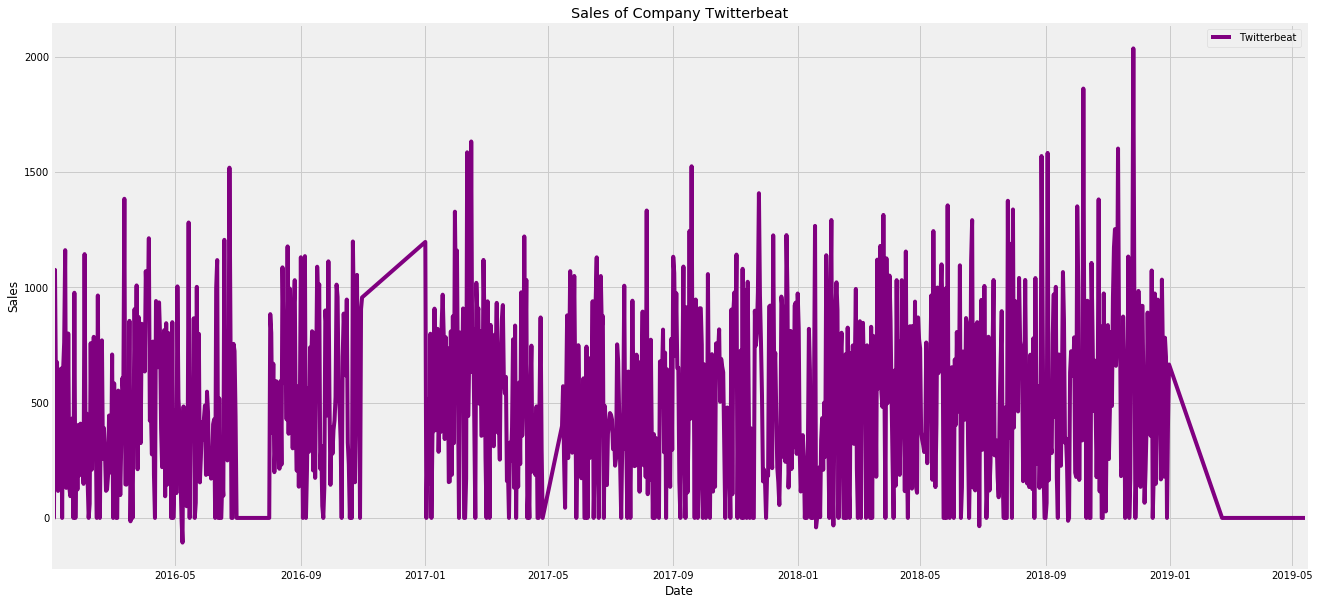

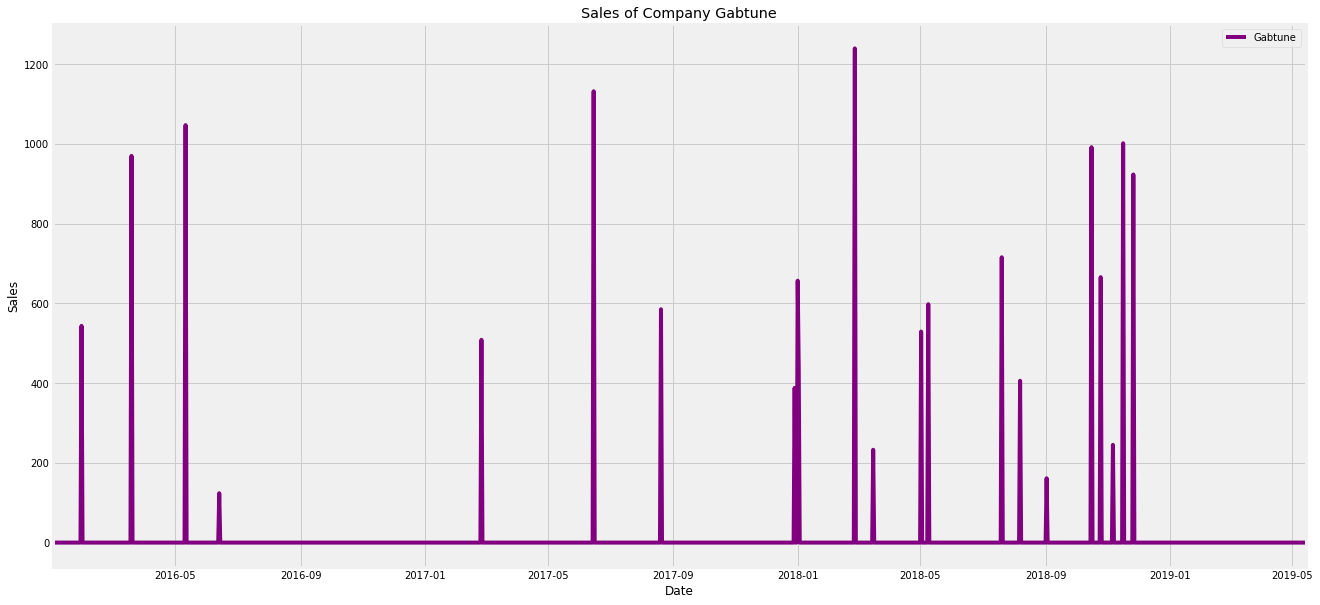

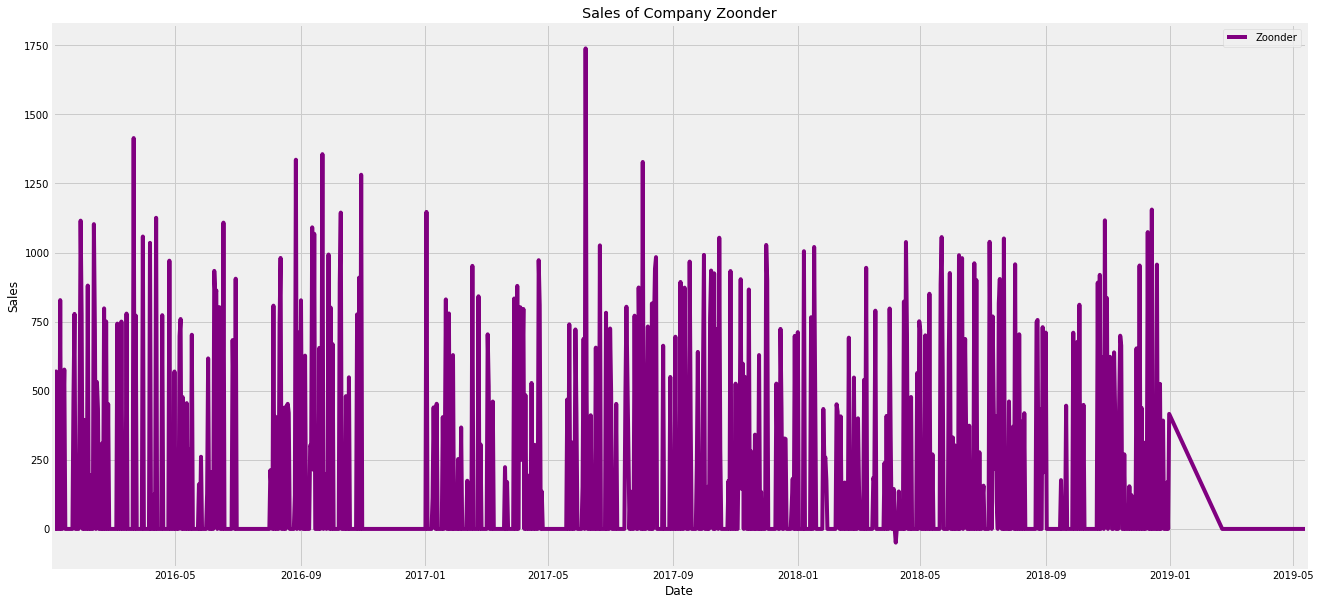

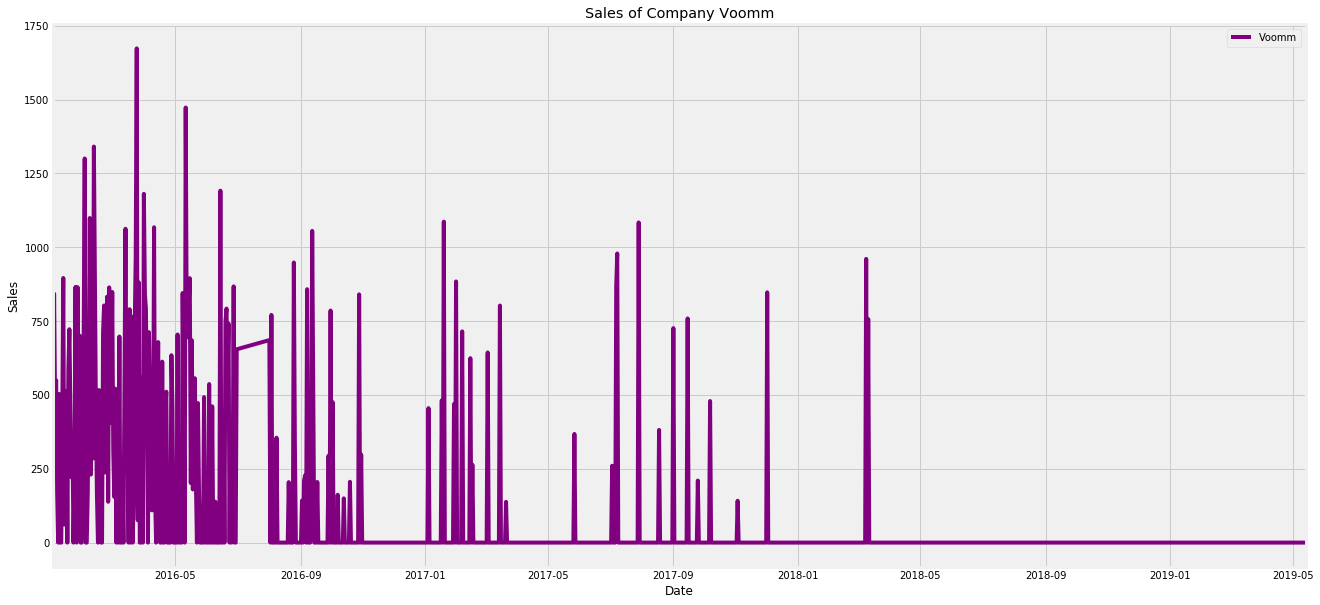

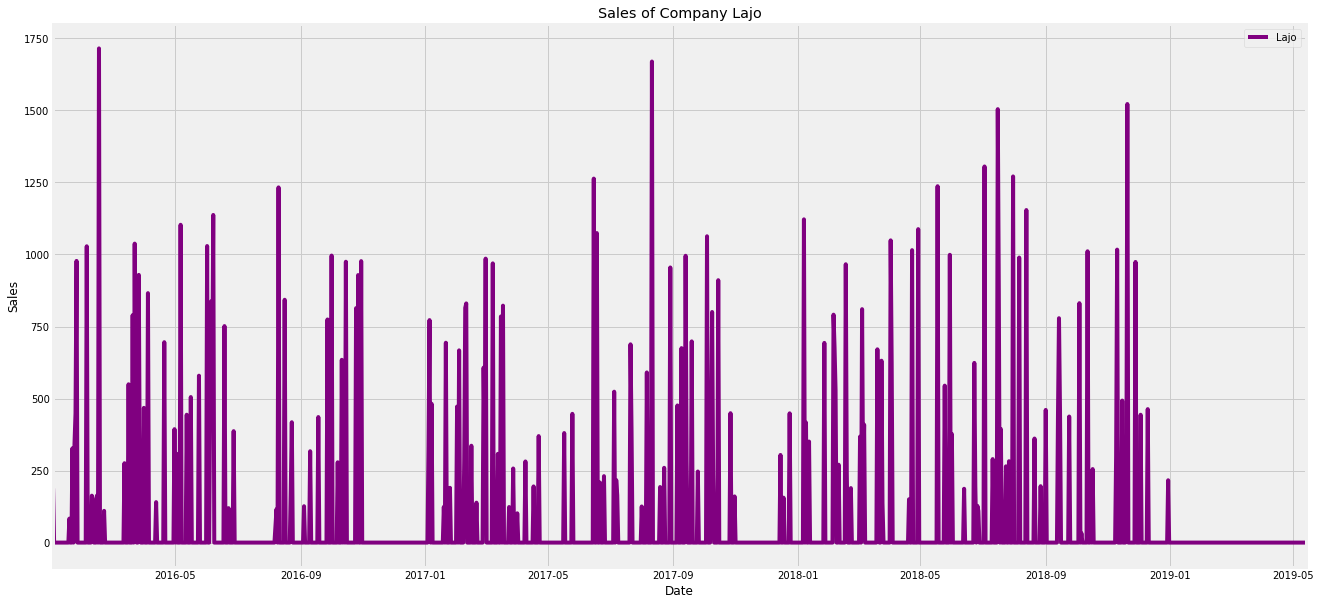

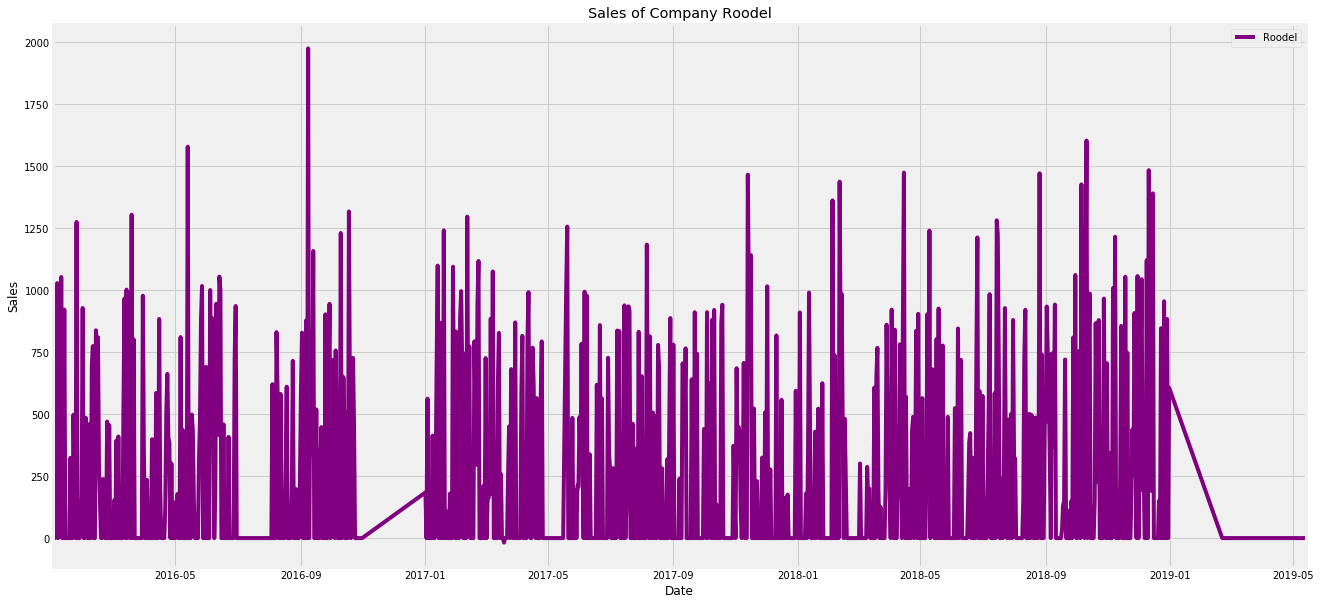

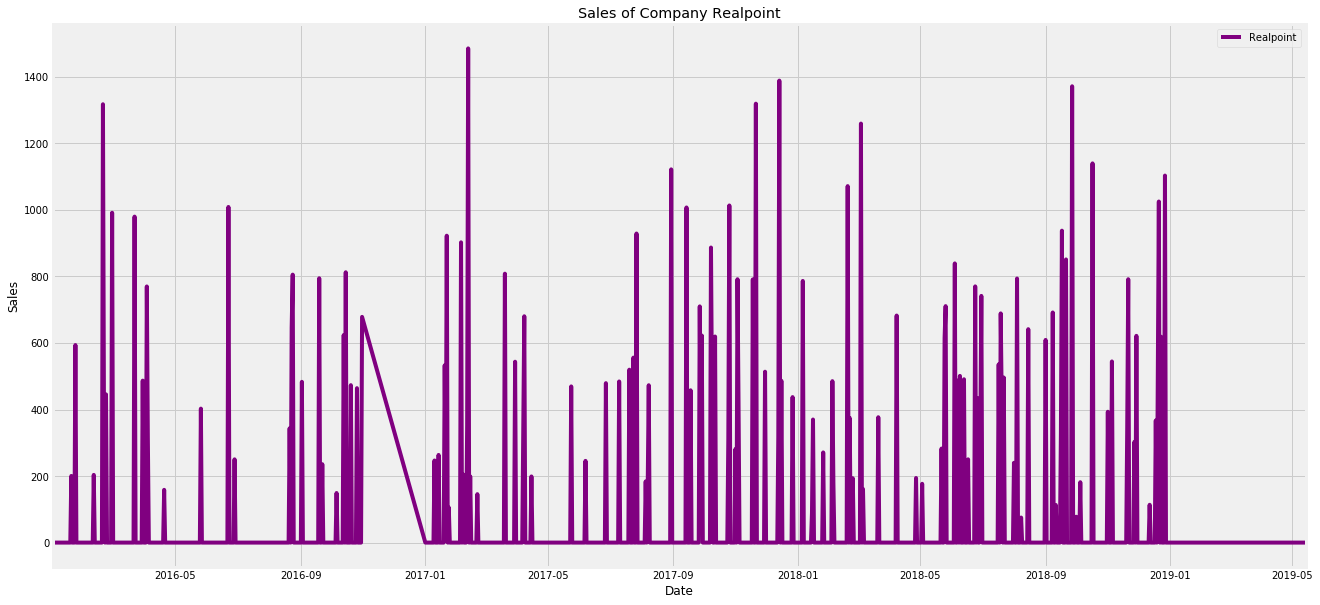

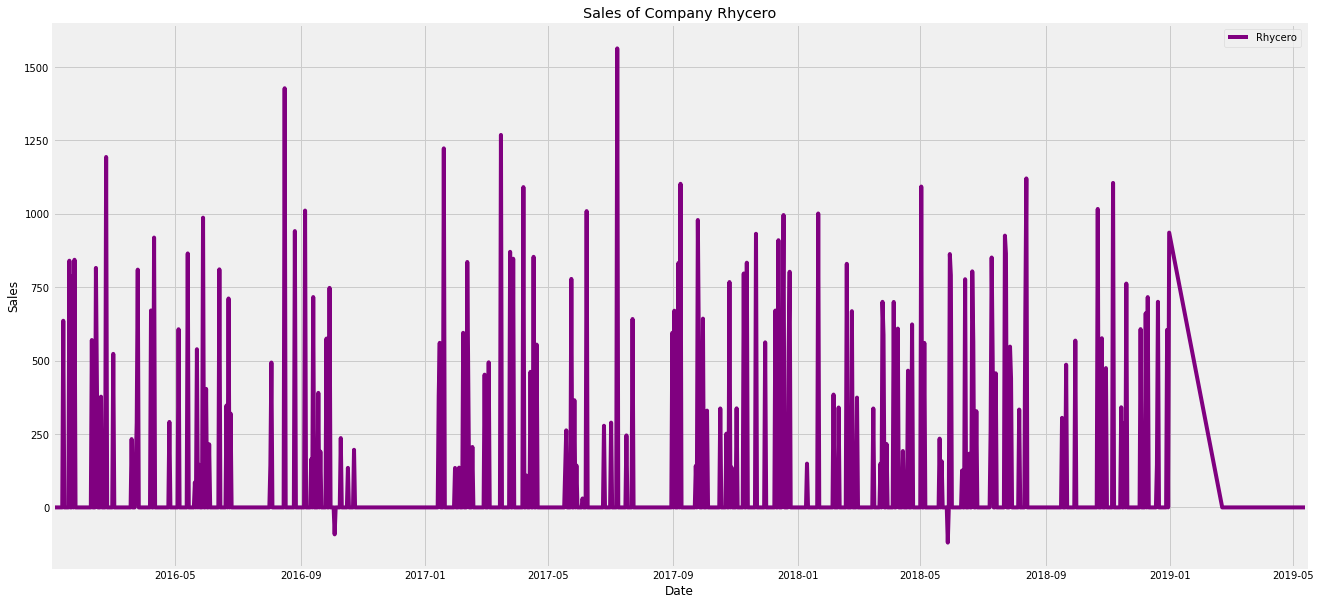

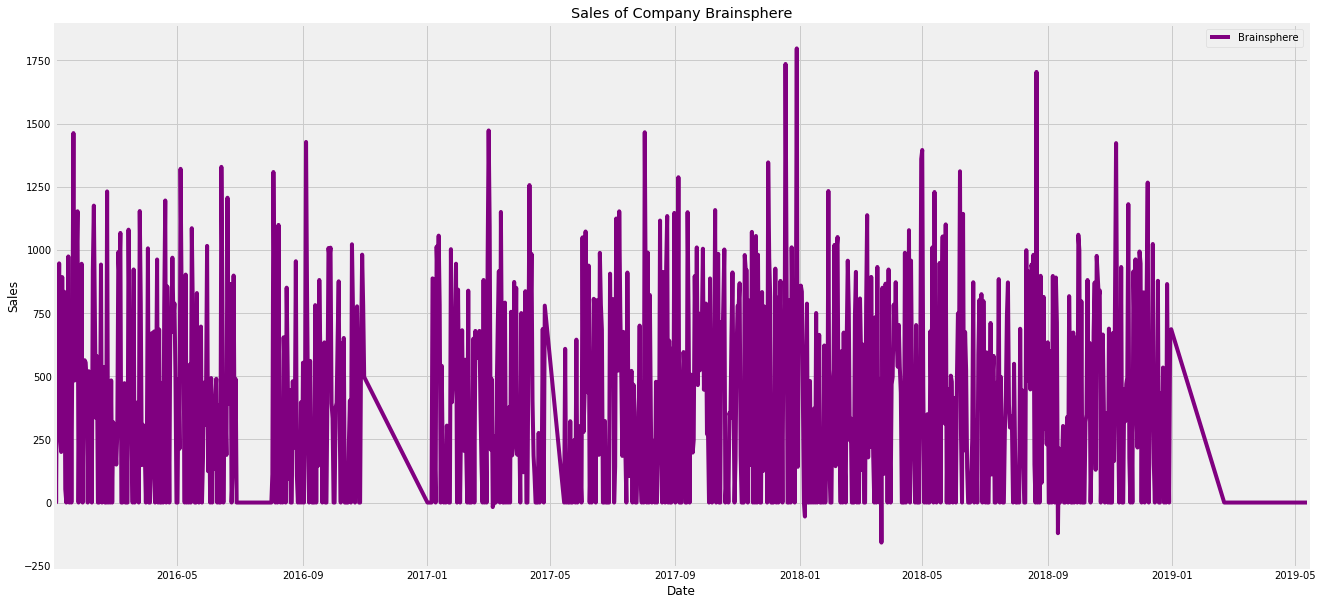

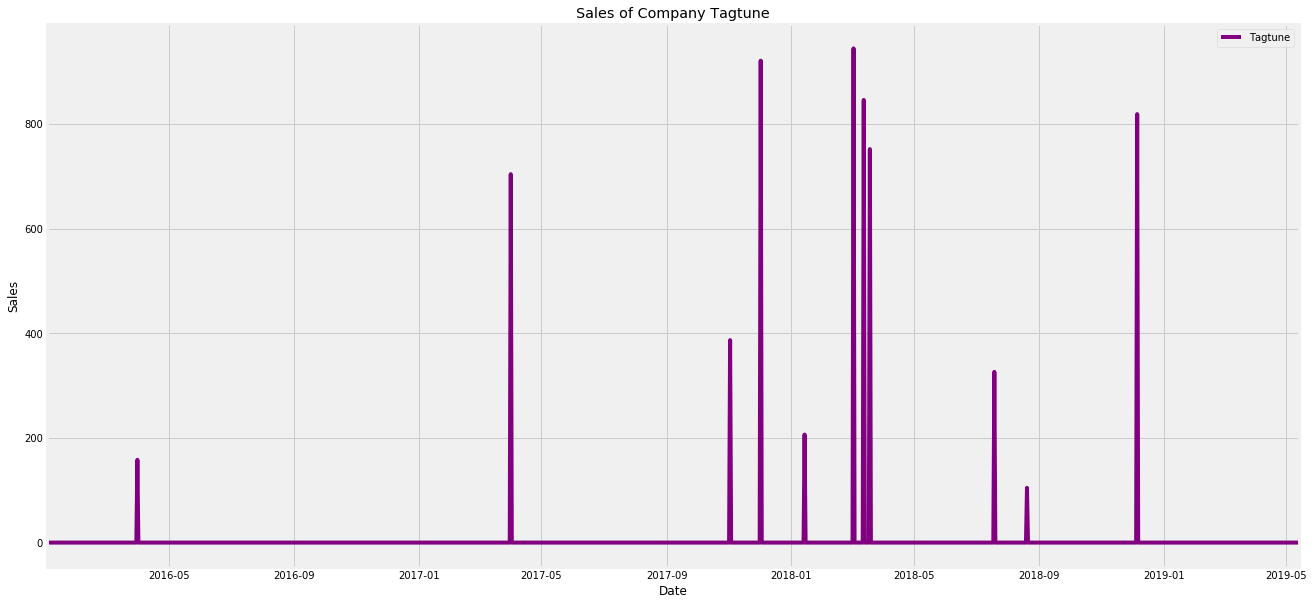

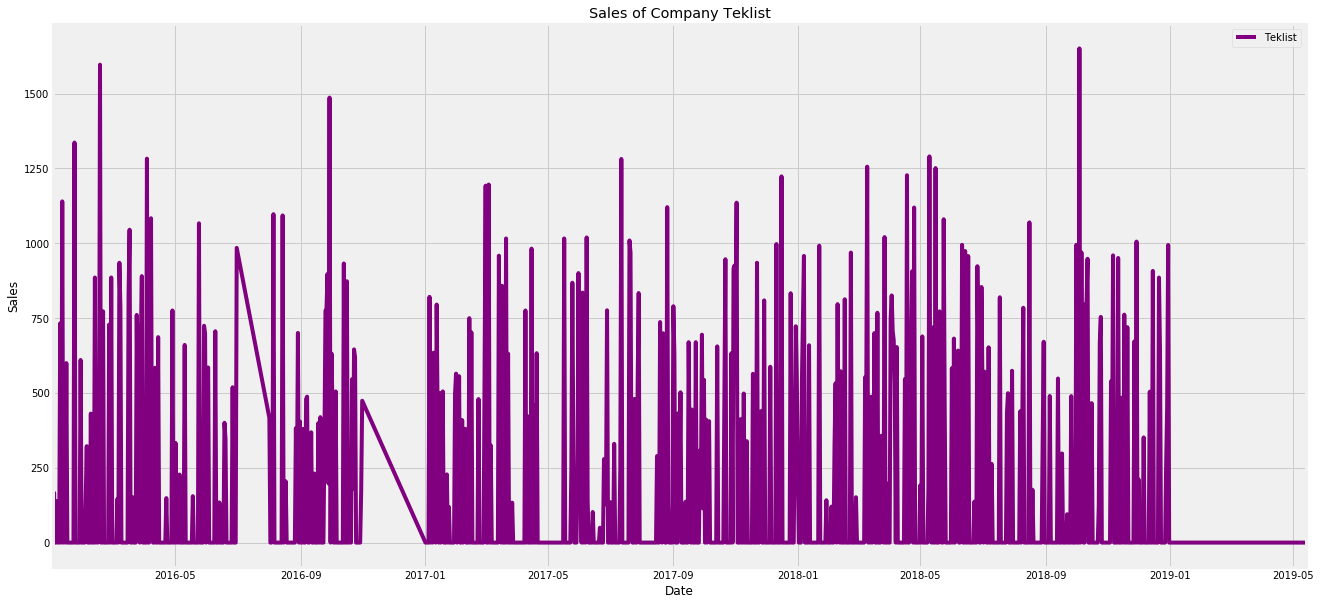

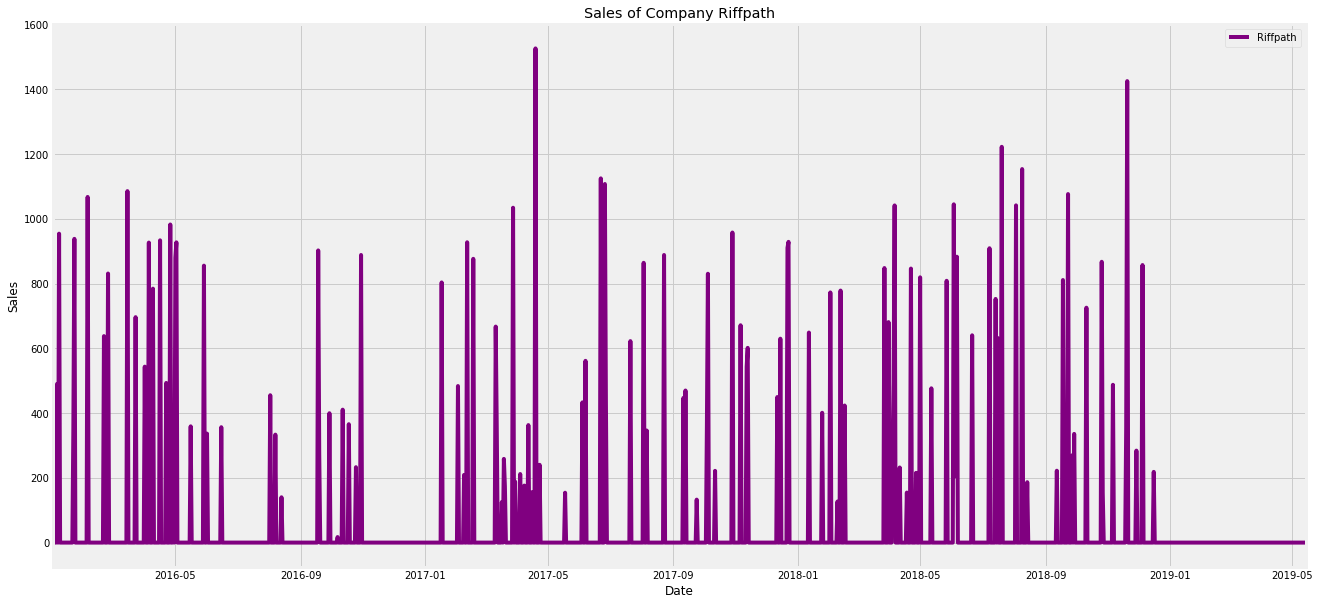

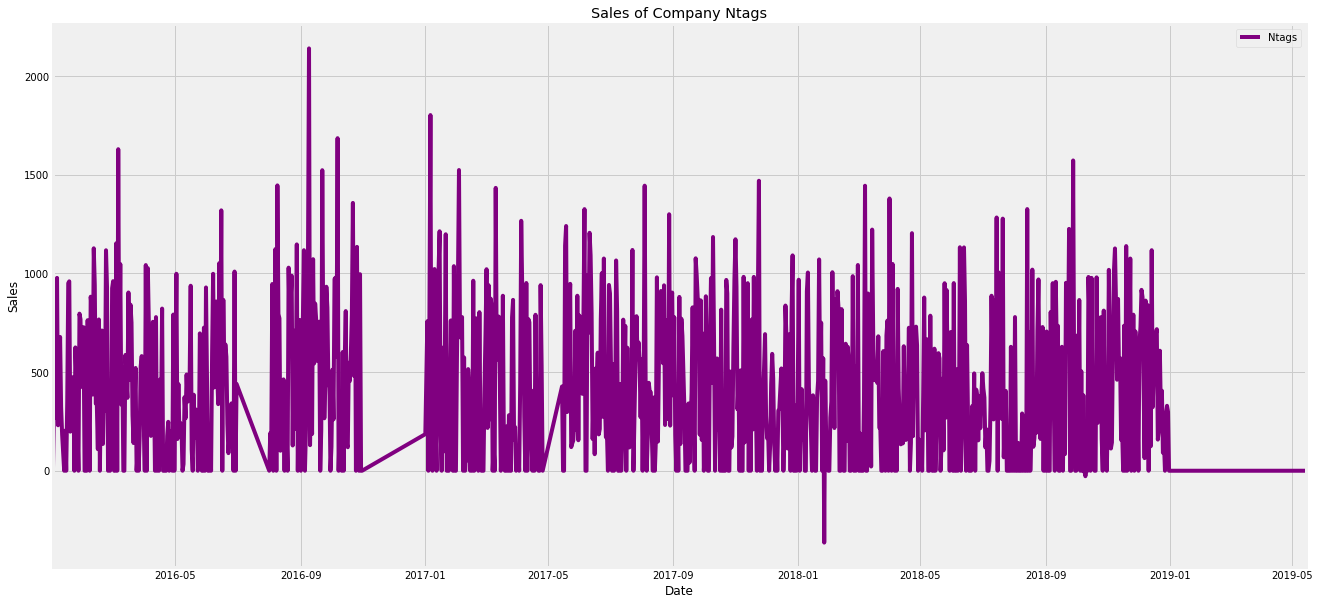

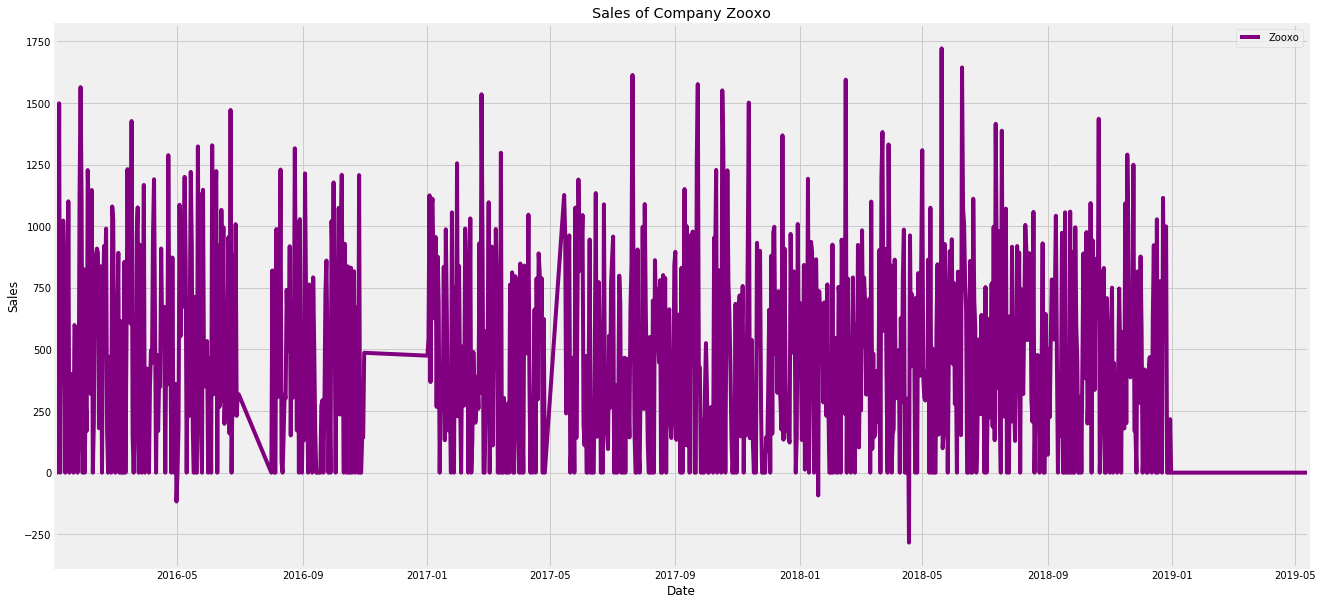

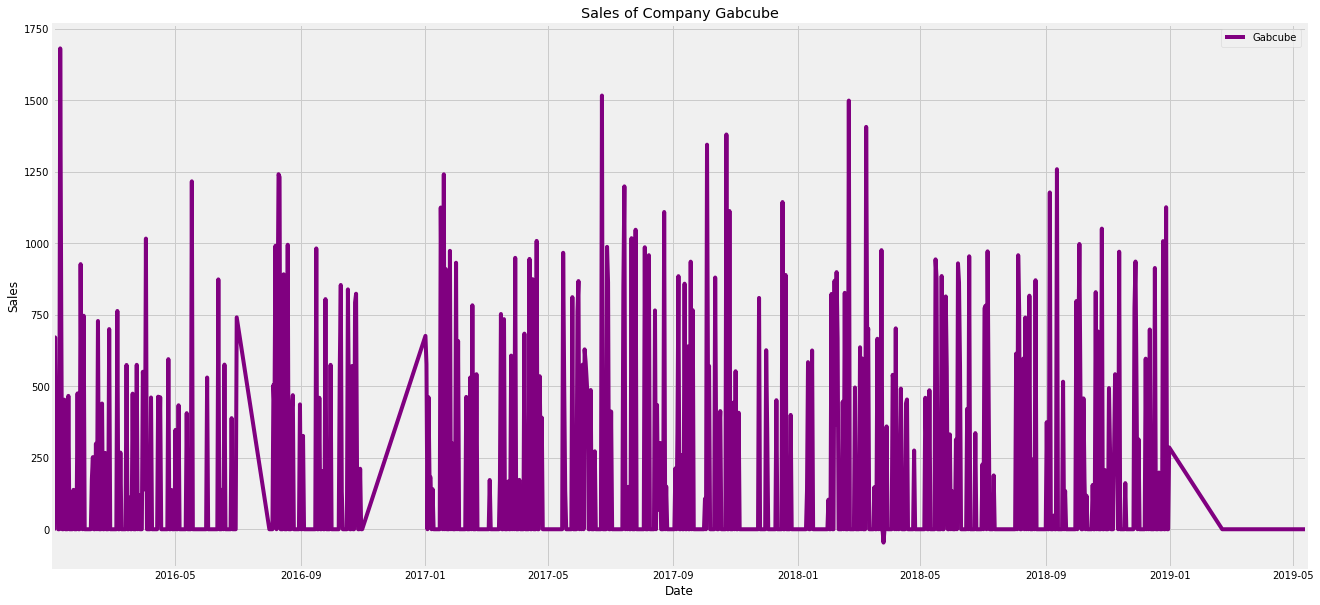

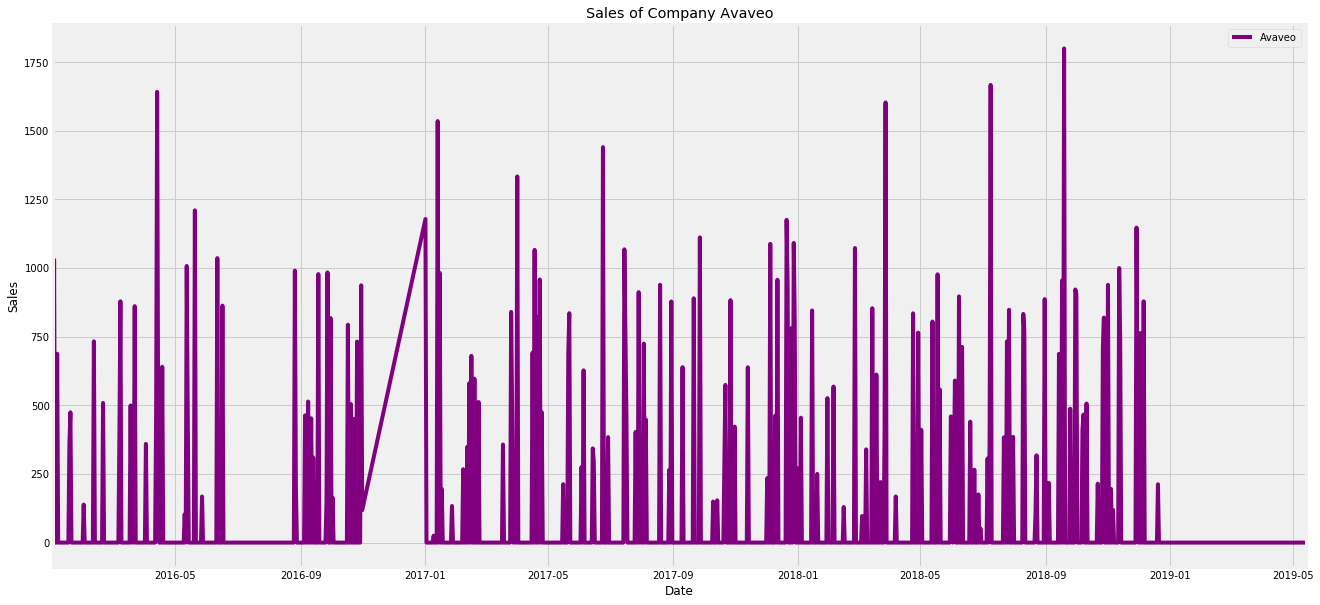

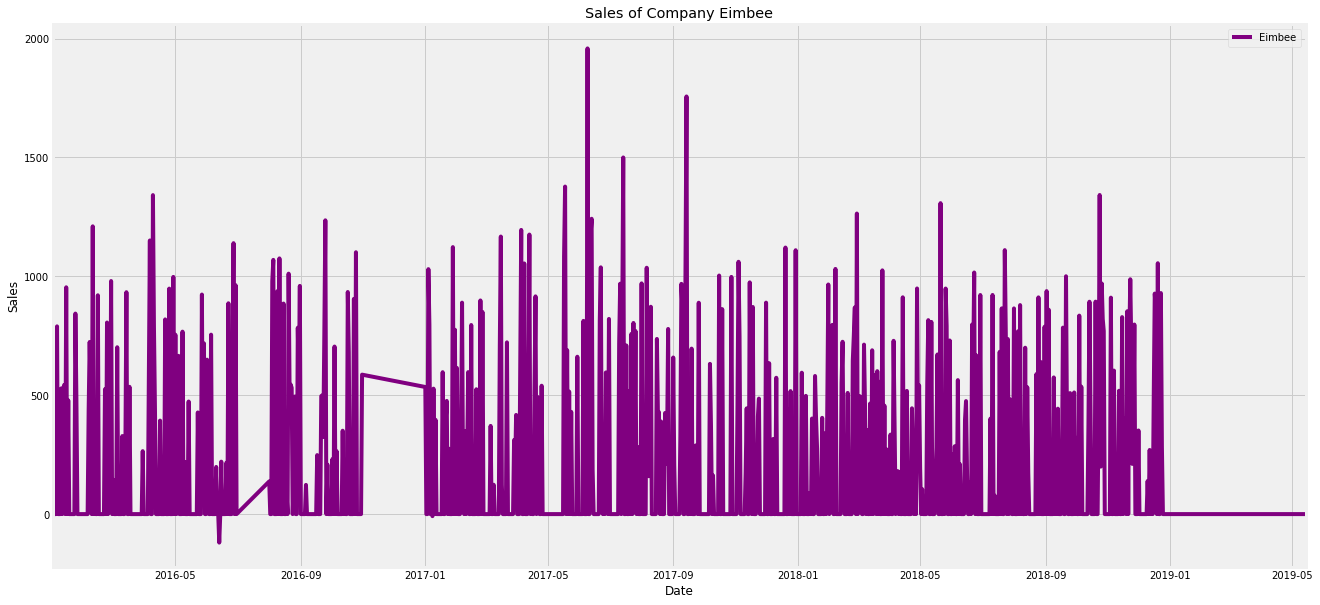

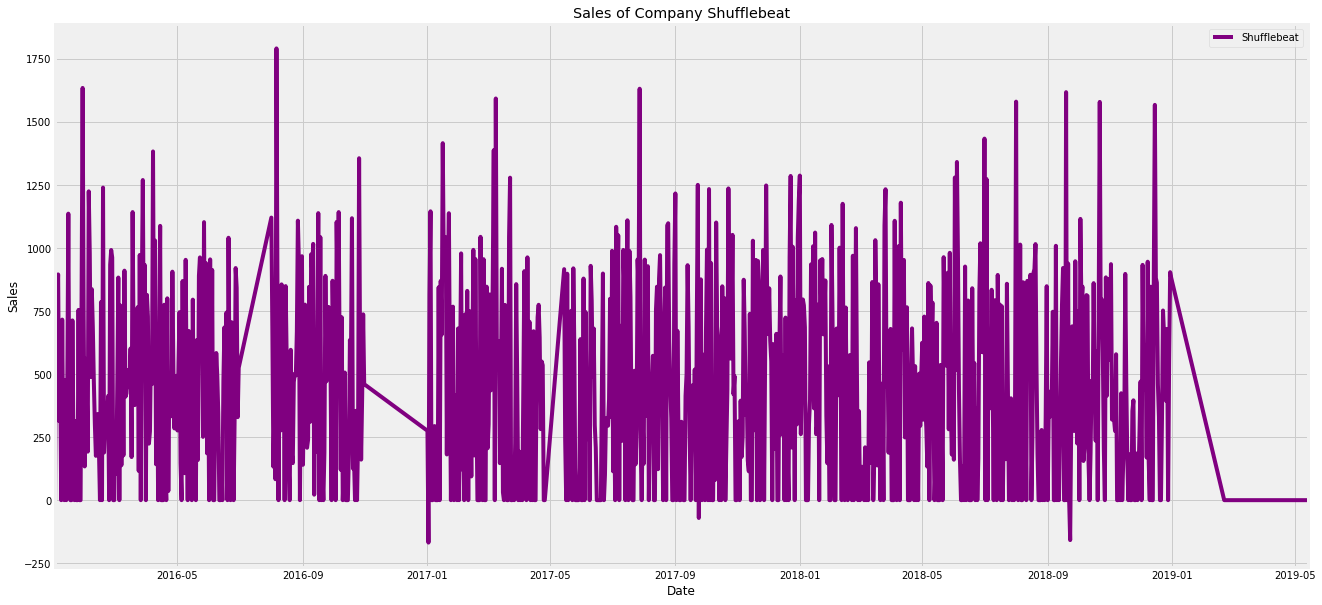

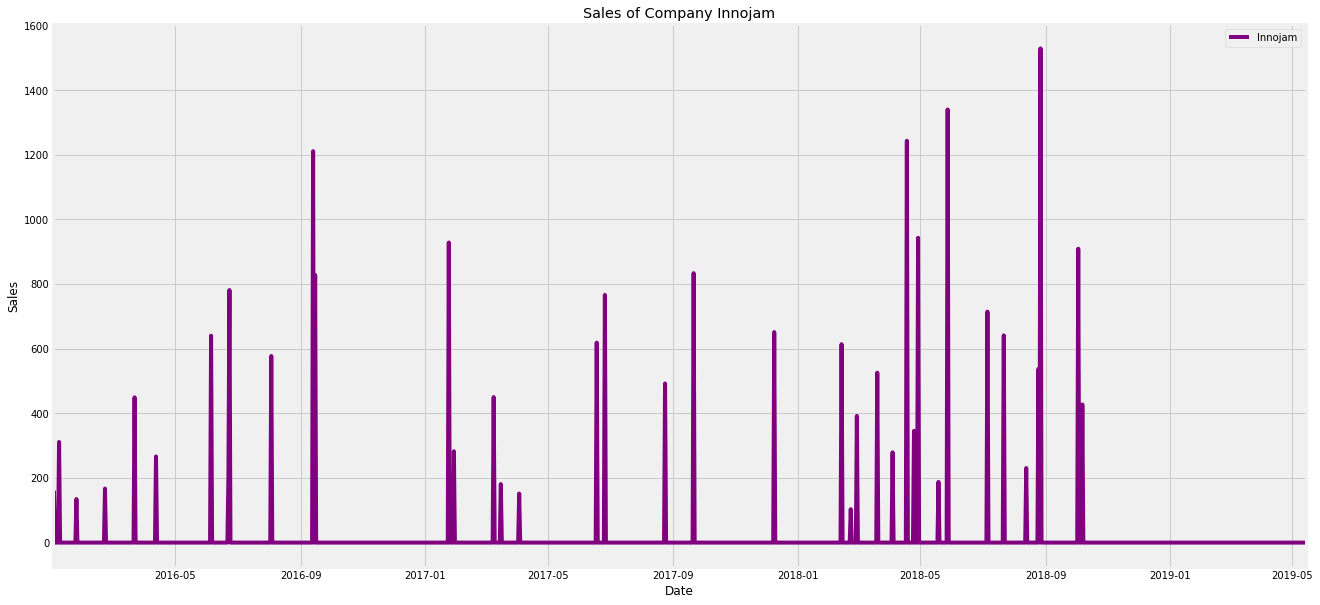

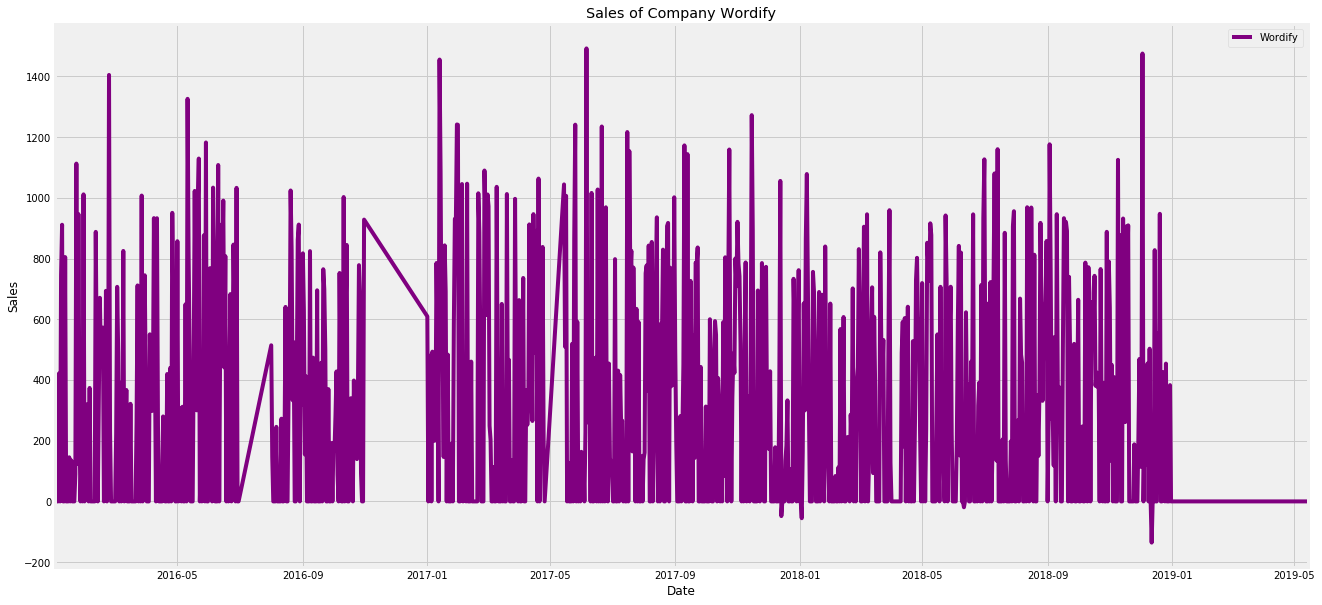

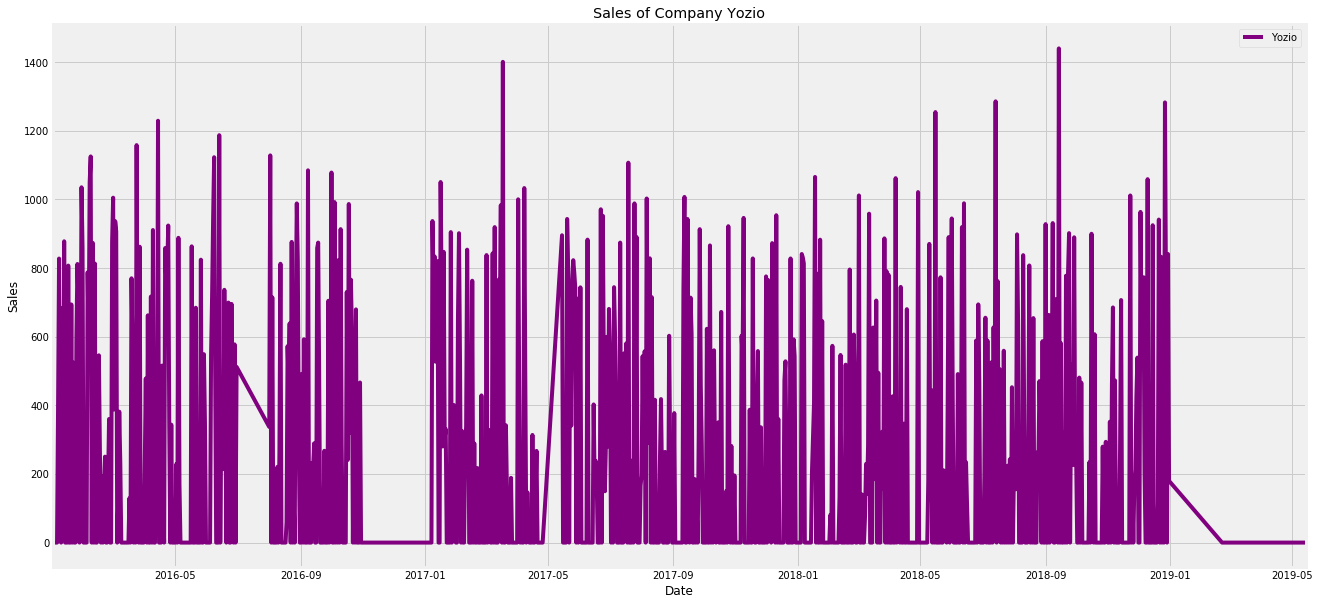

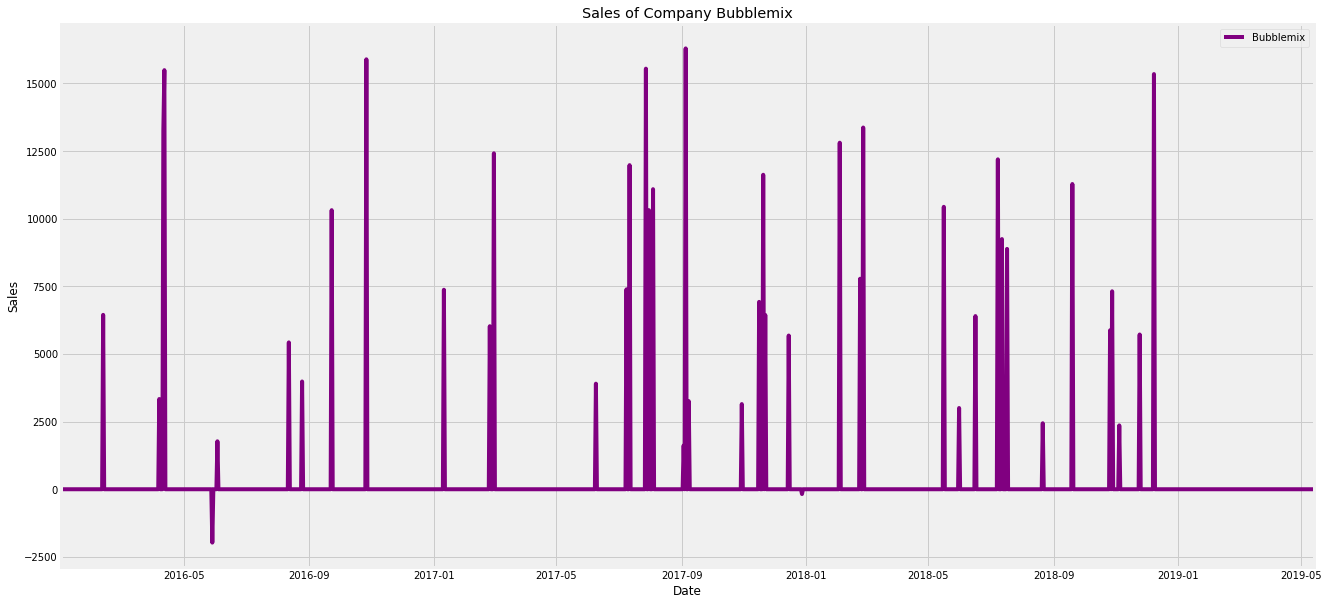

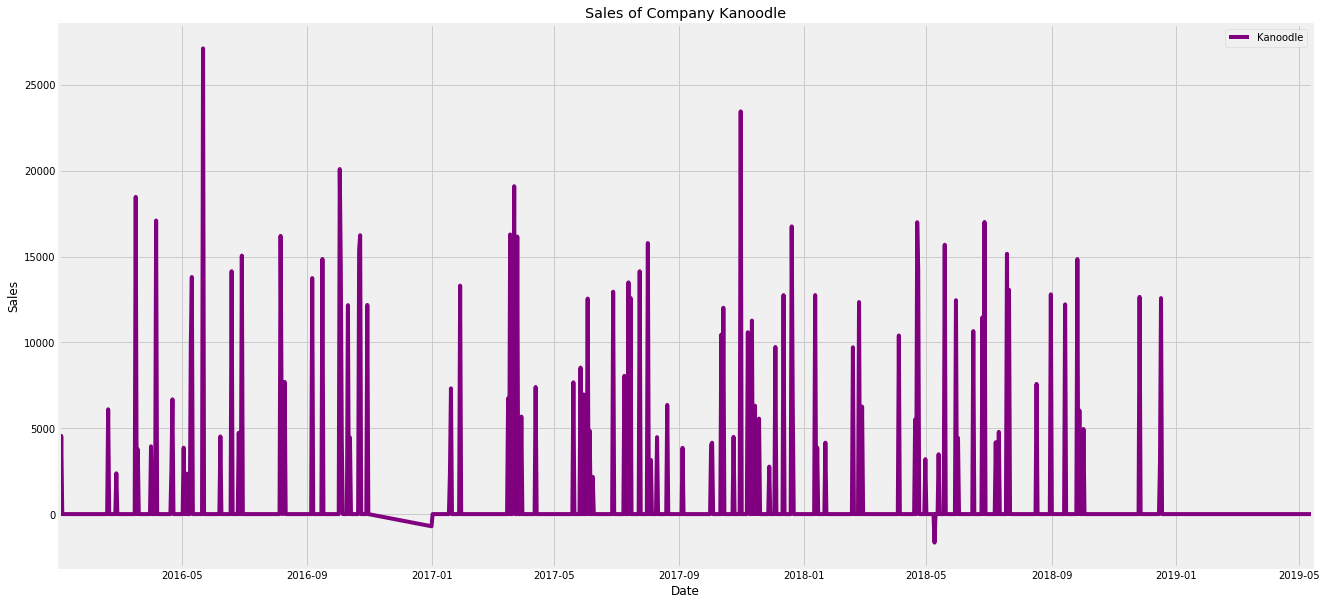

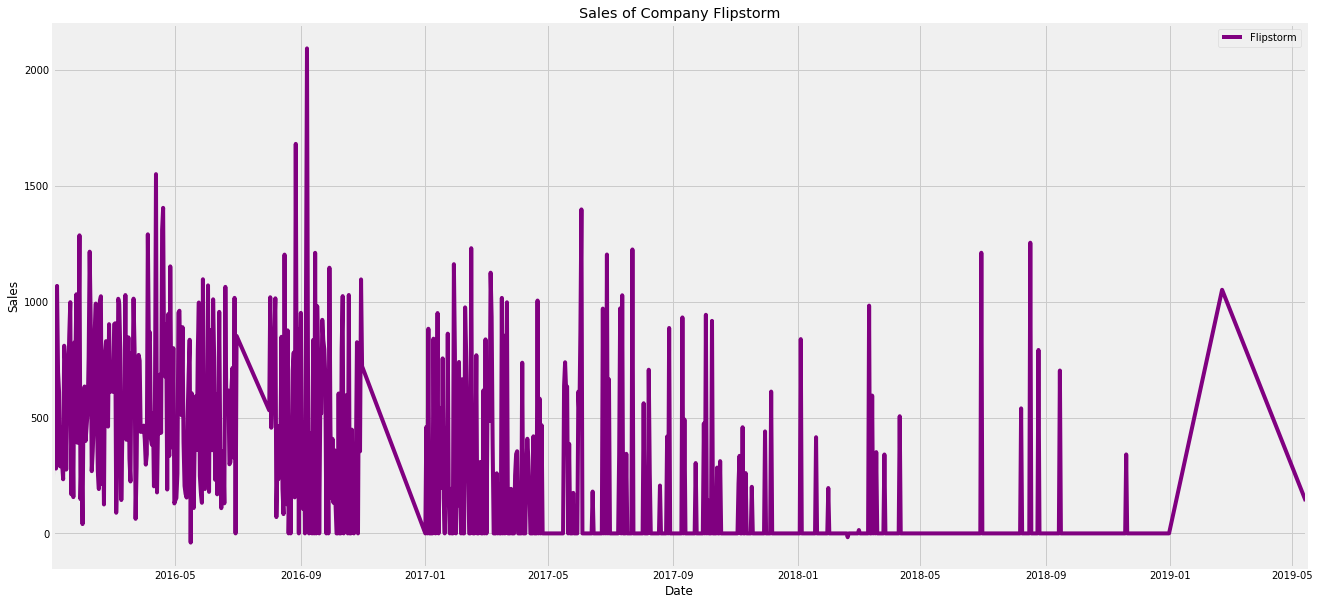

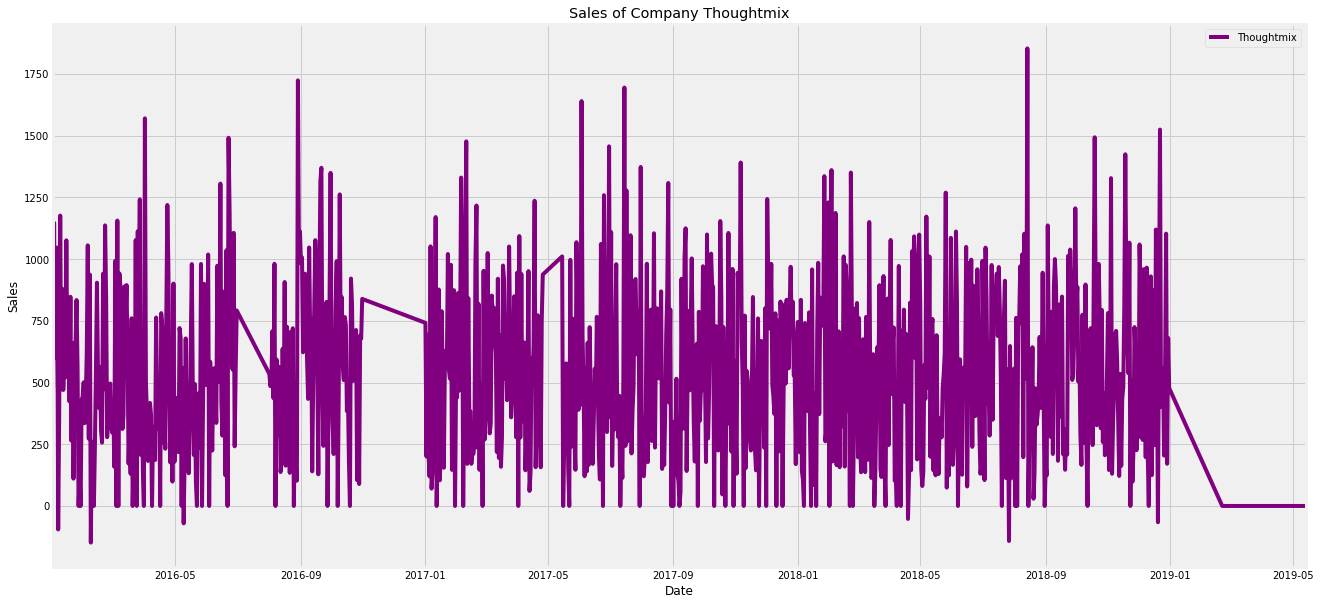

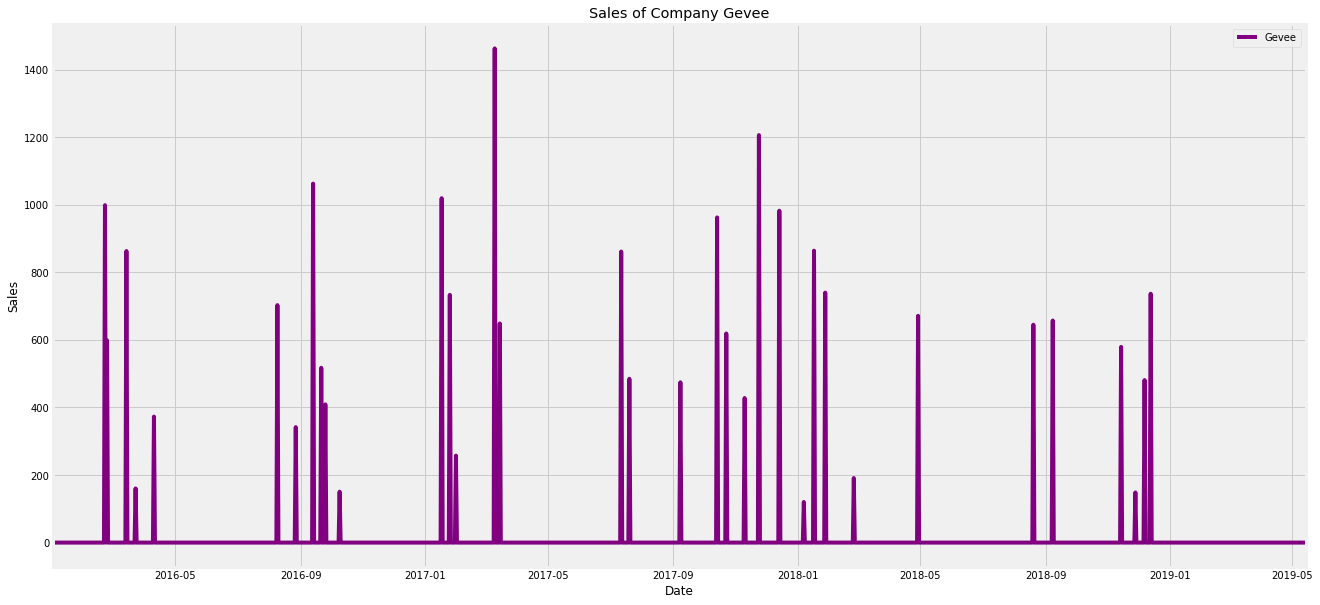

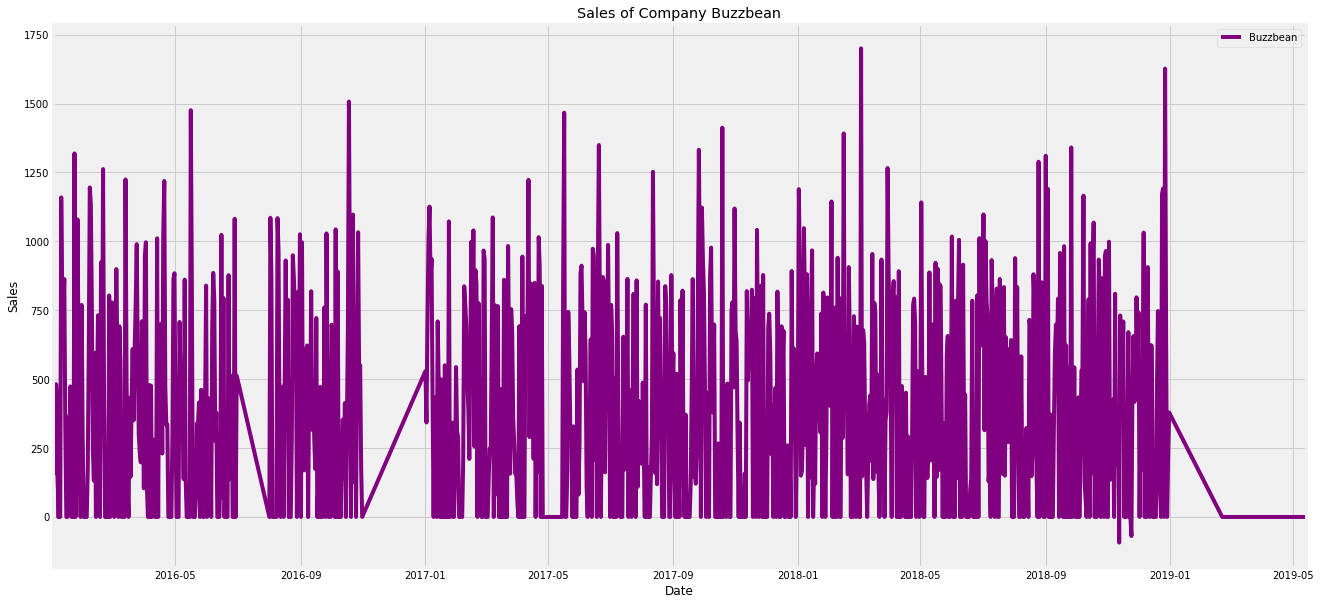

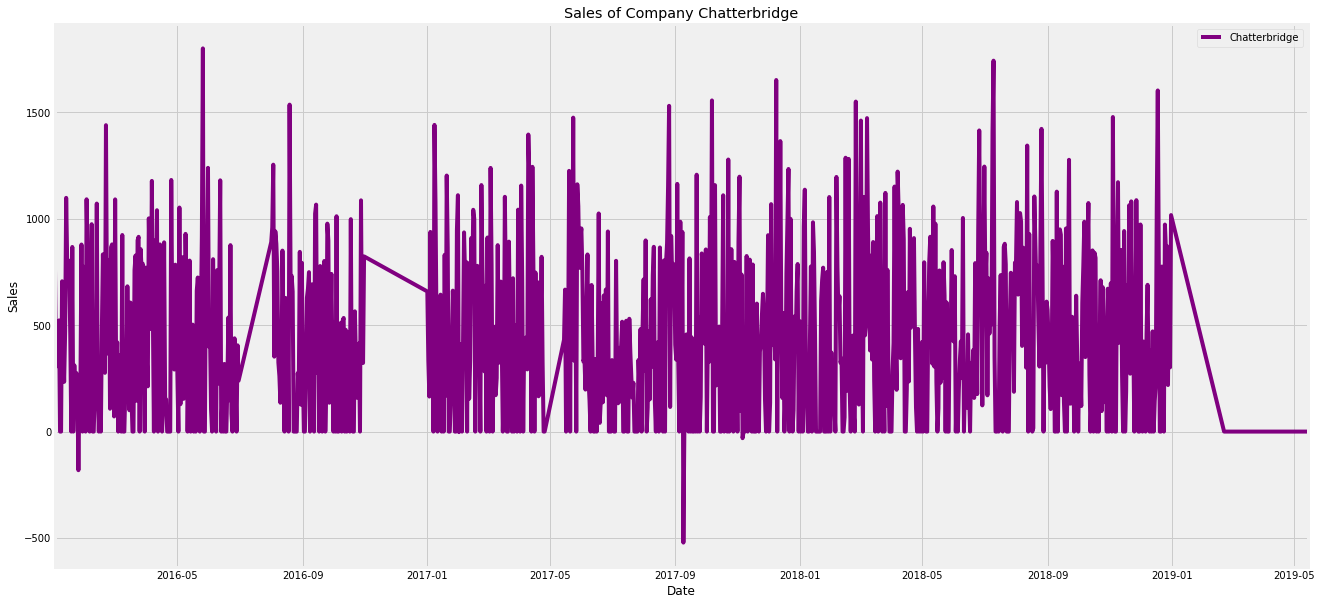

In [32]:
comp = list(set(df_2["companies"]))
for i in range(len(comp)):
    df_2_1.plot(x='dates', y=comp[i],figsize=(20,10), color='purple')
    plt.ylabel('Sales')
    plt.xlabel('Date')
    plt.title("Sales of Company {}".format(comp[i]))
    plt.show()

When the plots are examined, it is pretty explicit that after 2019-01-01 there is a sharp decrease in sales. Profits are amazingly declining after new year of 2019. For the company Flipstorm after the date of 2018-01, sales are more rare than year 2016. So, profit is declining. There is gap between from ~2016-09 to ~2017-01 nearly for the all companies. This gap should be examined, since the sales are really low there. For the company Voom, sales are pretty less than the date of ~2016-05 when it is compared to ~2017 and further. For further analysis, time series analysis should be implemented.

# Our Question: Which of the countries are most profitable and more attractive?

In [33]:
data["country"].unique()

array(['Spain', 'Greece', 'France', 'Germany', 'United Kingdom',
       'Portugal', 'United States', 'Netherlands', 'Japan', 'Switzerland'],
      dtype=object)

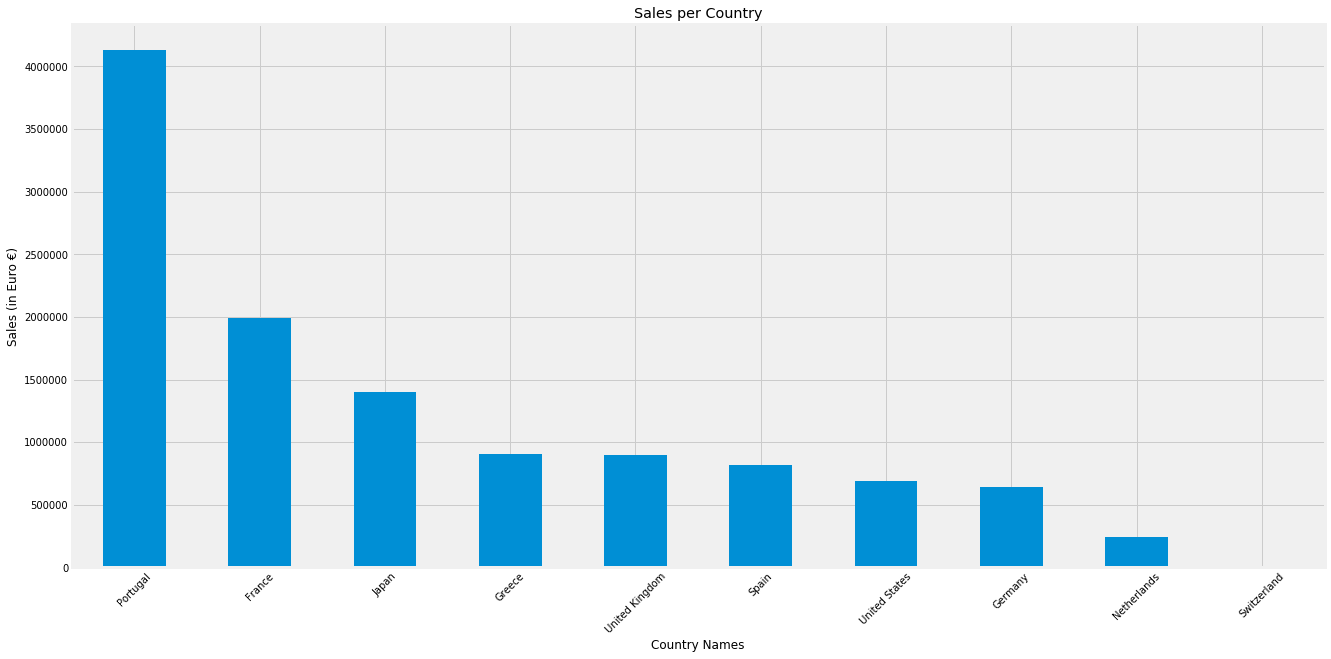

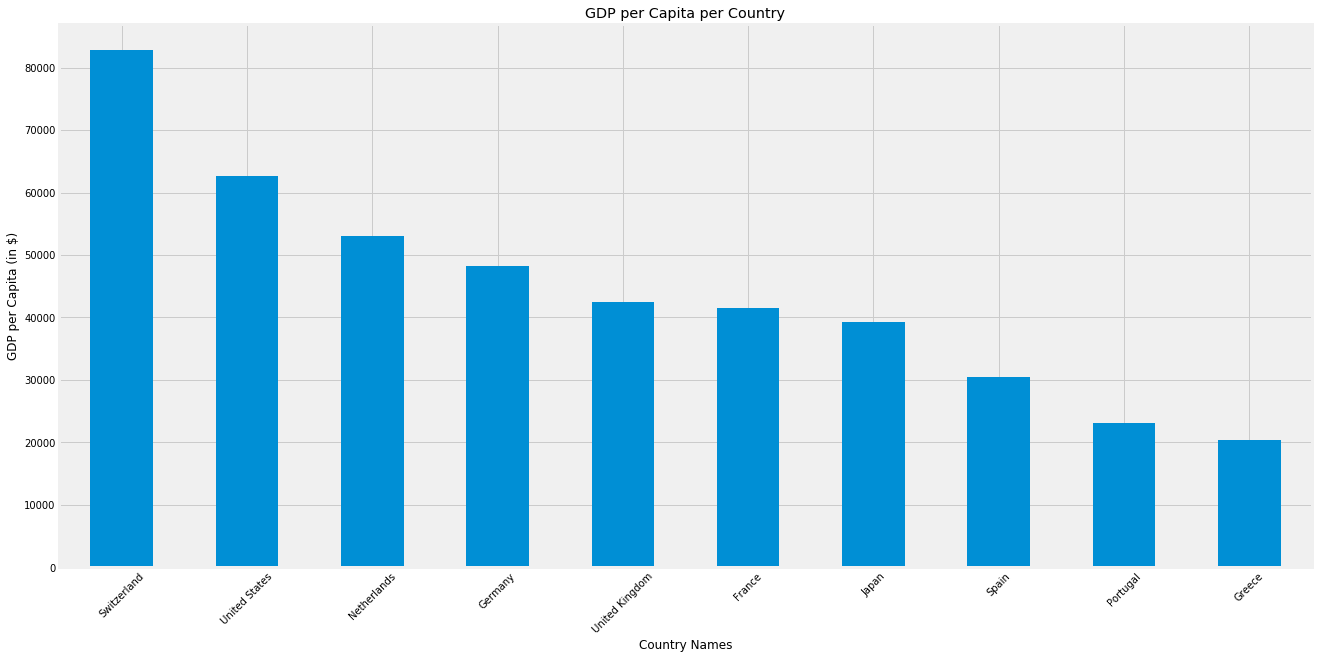

In [34]:
query_W = "SELECT C_Name, GDP_2018 FROM GDP_Per_Capita WHERE C_Name IN ('Spain', 'Greece', 'France', 'Germany', 'United Kingdom','Portugal', 'United States', 'Netherlands', 'Japan', 'Switzerland')" 
c.execute(query_W)        
Country = []
GDP = []
for row in c.fetchall():
    Country.append(row[0])
    GDP.append(row[1])
df_w = pd.DataFrame()
df_w["Country"] = Country
df_w["GDP_value"] = GDP

query_y = "SELECT eur_value, country FROM transactions GROUP BY country, eur_value ORDER BY country, eur_value;"
c.execute(query_y)
eur_values_y = []
countries_y = []
for eur, country in c.fetchall():
    eur_values_y.append(eur)
    countries_y .append(country)
df_y = pd.DataFrame()
df_y["eur_values"] = eur_values_y
df_y["countries"] = countries_y

plt.rcParams['figure.figsize'] = [20, 10]
df_y.groupby('countries')['eur_values'].sum().sort_values(ascending=False).plot.bar(y='eur_values', rot=45)
plt.xlabel("Country Names")
plt.ylabel("Sales (in Euro €)")
plt.title("Sales per Country")
plt.show()

df_w.groupby('Country')['GDP_value'].sum().sort_values(ascending=False).plot.bar(y='GDP_value', rot=45)
plt.xlabel("Country Names")
plt.ylabel("GDP per Capita (in $)")
plt.title("GDP per Capita per Country")
plt.show()

Plots above are amazing. Because it shows us that actually we are working with mostly with worser economies when it compared according to GDP per capita value. To work with better economic countries, either we should enhance our quality of product or enhance our product portfoli and do a good market research to play in better economies. For now, for us Portugal seems more profitable, but maybe after a economic inflation or other bad things, our business will most probably collapse. If we work with better countries we will more oppurtunity to survive. As a result, we should sell our products to better countries in terms of better economic indicators.

# Which companies returns parts?

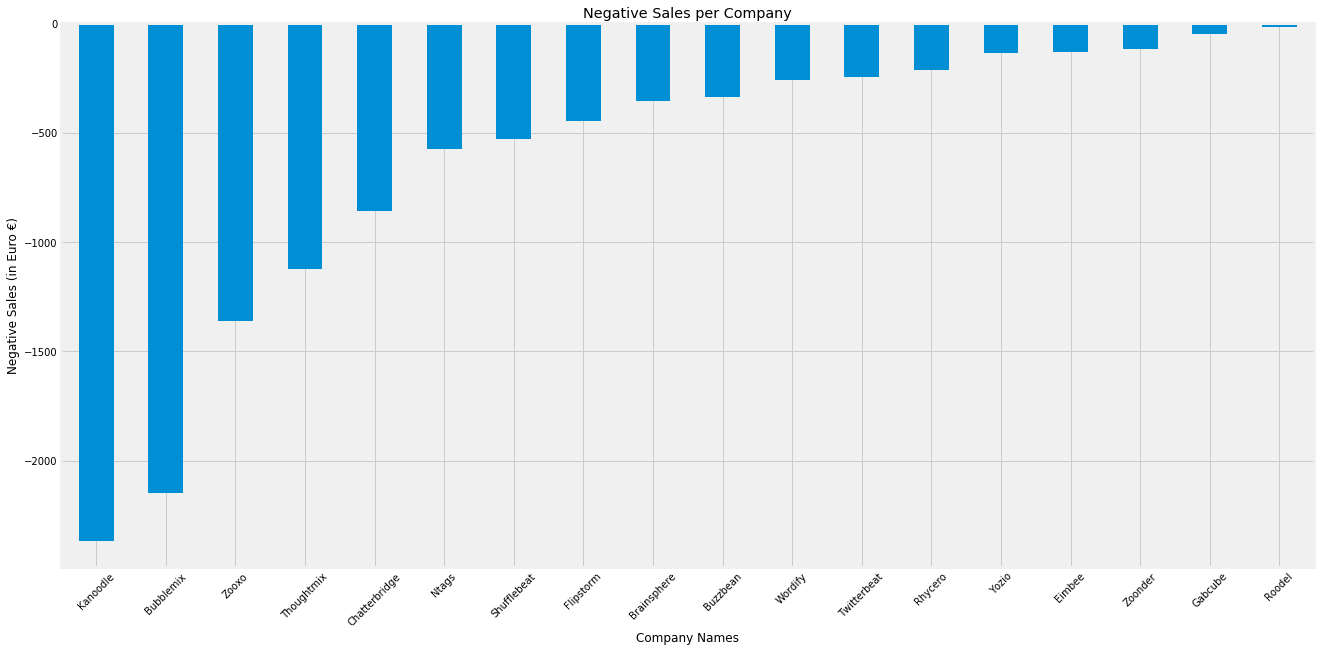

In [35]:
query_z = "SELECT eur_value, company FROM transactions WHERE eur_value < 0 GROUP BY company, eur_value ORDER BY company, eur_value;"
c.execute(query_z)
eur_values_z = []
countries_z = []
for eur, country in c.fetchall():
    eur_values_z.append(eur)
    countries_z .append(country)
df_z = pd.DataFrame()
df_z["eur_values"] = eur_values_z
df_z["company"] = countries_z

plt.rcParams['figure.figsize'] = [20, 10]
df_z.groupby('company')['eur_values'].sum().sort_values(ascending=True).plot.bar(y='eur_values', rot=45)
plt.xlabel("Company Names")
plt.ylabel("Negative Sales (in Euro €)")
plt.title("Negative Sales per Company")
plt.show()

From the figure above, it is pretty obvious that company should be very careful while having transaction with the companies above especially with "Kanoodle", "Bubblemix", "Zooxo", "Chatterbridge" since they return products and it costs money for us.

---
## Part 5: Performance
Your boss is very impressed with what you have achieved in less than two weeks, and he would like to take your idea of storing the customer and sales data in a relational database to production. However, John is concerned that the solution will not scale. His experience is telling him that you will see many occurrences of the following queries.

- Show all sales to company X between time $t_1$ and time $t_2$
- Show the latest X sales in the database
- Show total sales per company per day

Show that Johns concern is not justified.

---
### Solution

- Show all sales to company X between time $t_1$ and time $t_2$

Company name and time $t_1$ and time $t_2$ are given as variables. It can be changed from the code easily. We have written nested query to obtain needed data. Then created a dataframe and then plotted.

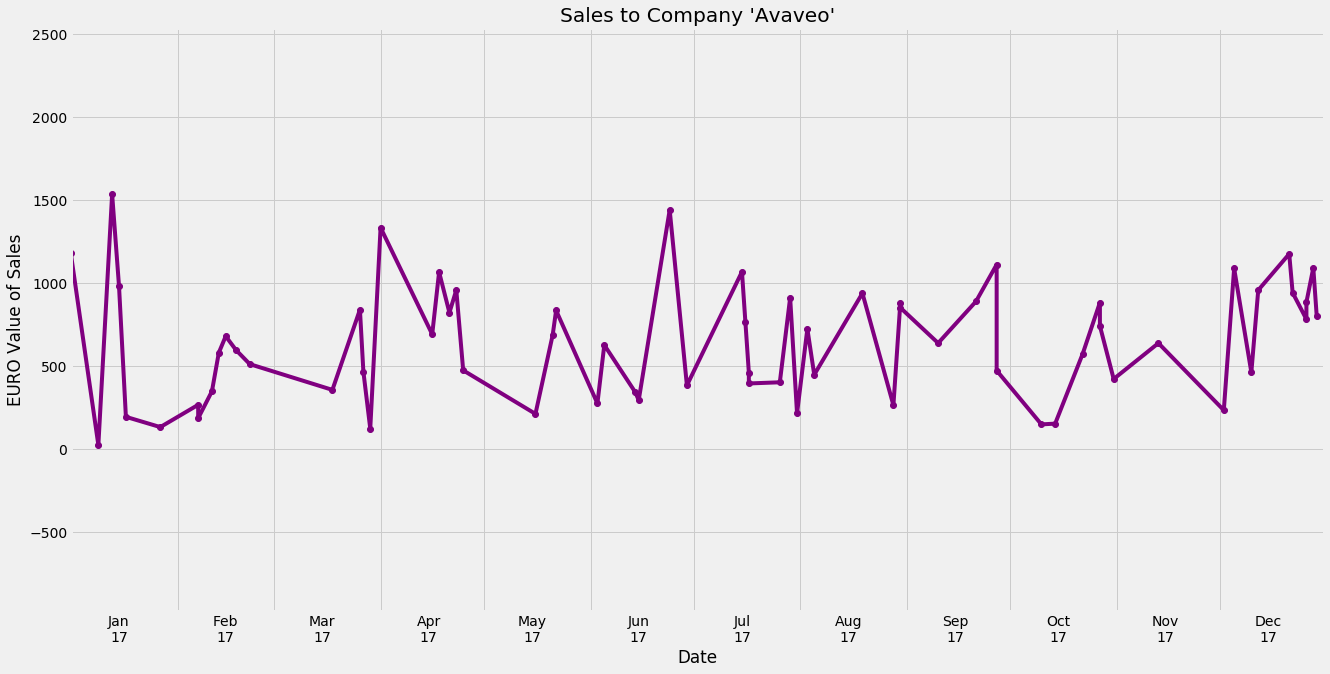

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.ticker import NullFormatter
from matplotlib import style
style.use("fivethirtyeight")
#plt.rcParams['figure.figsize'] = [20, 10]

import datetime
data["day"] = pd.to_datetime(data["day"])
data["day"] = data["day"].apply(lambda x: x.date())

t1 = "'2017-01-01'"
t2 = "'2017-12-31'"
company_name = "'Avaveo'"
query_a = "SELECT eur_value, day, company  FROM (SELECT company, eur_value, day FROM transactions WHERE company = "+ company_name+") WHERE day BETWEEN " + t1 + " AND " + t2
c.execute(query_a)
            
dates = []
eur_values = []
company = []
for eur, date, comp in c.fetchall():
    dates.append(date)
    eur_values.append(eur)
    company.append(comp)
df_a = pd.DataFrame()
df_a["dates"] = dates
df_a["company"] = company
df_a["eur_values"] = eur_values
df_a["dates"] = pd.to_datetime(df_a["dates"])
df_a["dates"] = df_a["dates"].apply(lambda x: x.date())


fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df_a["dates"], df_a["eur_values"], '-o', color='purple')
ax.set(xlabel="Date", ylabel="EURO Value of Sales",title="Sales to Company {}".format(company_name))

# set dates limits
ax.set_xlim(['2017-01-01', '2017-12-31'])
ax.set_ylim([min(df_a["eur_values"])-1000, max(df_a["eur_values"])+1000])

# formatters' options
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b\n%y'))

plt.show()

- Show the latest X sales in the database

Latest X sales are find out with rowid. We have find out latest 500 sales. Again data retrieved from database and then, a new dataframe is created. Also, we have retrieved date to plot it better.

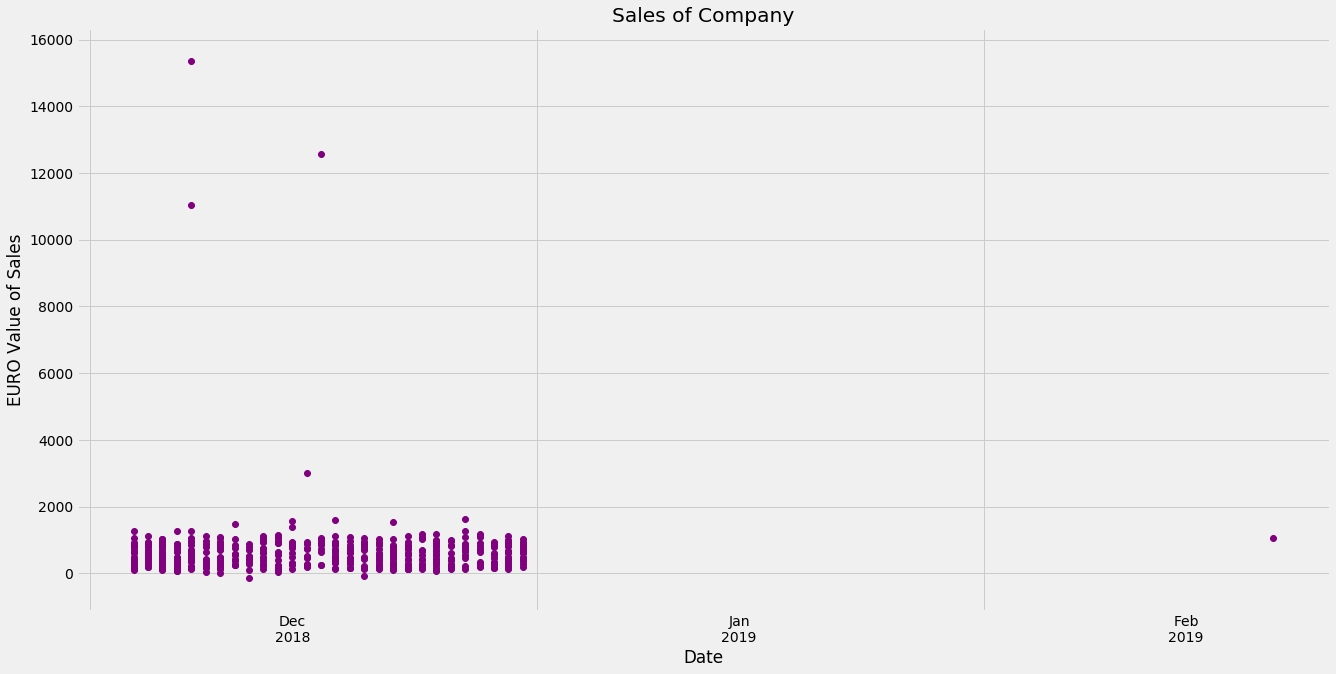

In [37]:
query_b = "SELECT eur_value, day FROM transactions WHERE rowid BETWEEN '17863' AND '18362';"
c.execute(query_b)
dates_b = []
eur_values_b = []

for eur, date in c.fetchall():
    dates_b.append(date)
    eur_values_b.append(eur)
    
df_b = pd.DataFrame()
df_b["dates"] = dates_b
df_b["eur_values"] = eur_values_b
df_b["dates"] = pd.to_datetime(df_b["dates"])
df_b["dates"] = df_b["dates"].apply(lambda x: x.date())


fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df_b["dates"], df_b["eur_values"], 'o', color='purple')
ax.set(xlabel="Date", ylabel="EURO Value of Sales",title="Sales of Company")

ax.set_ylim([min(df_b["eur_values"])-1000, max(df_b["eur_values"])+1000])

# formatters' options
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b\n%Y'))

plt.show()

- Show total sales per company per day

Total sales per company per day are depicted. Again data retrieved from database and then dataframe created. Then again new dataframe df_c_1 is created to make plot easier. We are aware of the fact that, plot is so complex to examine visually. But this is the only way to see total sales per company per day.

In [38]:
query_c = "SELECT eur_value, company, day FROM transactions GROUP BY day, company ORDER BY company, day;"
c.execute(query_2)

dates_c = []
eur_values_c = []
companies_c = []
for eur, company, date in c.fetchall():
    eur_values_c.append(eur)
    companies_c.append(company)
    dates_c.append(date)
df_c = pd.DataFrame()
df_c["dates"] = dates_c
df_c["eur_values"] = eur_values_c
df_c["companies"] = companies_c
df_c["dates"] = pd.to_datetime(df_c["dates"])
df_c["dates"] = df_c["dates"].apply(lambda x: x.date())


comp = list(set(df_c["companies"]))
dates = list(set(df_c["dates"]))
result_c = np.zeros((len(set(df_c["dates"])), len(set(df_c["companies"]))))

for i in range(len(dates)):
    for j in range(len(comp)):
            tmp = df_c.loc[df_c["companies"] == comp[j], :]
            try:
                tmp = tmp.loc[tmp["dates"] == dates[i], :]
                result_c[i, j] = tmp["eur_values"]
            except:
                pass
df_c_1 = pd.DataFrame(resul, index = dates, columns = comp)
df_c_1.head(5)

,Twitterbeat,Gabtune,Zoonder,Voomm,Lajo,Roodel,Realpoint,Rhycero,Brainsphere,Tagtune,...,Innojam,Wordify,Yozio,Bubblemix,Kanoodle,Flipstorm,Thoughtmix,Gevee,Buzzbean,Chatterbridge
2016-02-12,455.00,0.0,720.283814,893.94,0.0,0.00,0.0,0.00,579.38,0.0,...,0.0,439.033259,813.34,6446.081712,0.0,882.8,243.22,0.0,595.56,1071.56
2017-06-16,246.89,0.0,0.000000,0.00,0.0,0.00,0.0,0.00,800.71,0.0,...,0.0,0.000000,165.46,0.000000,0.0,0.0,556.06,0.0,208.45,0.00
2018-10-09,651.21,0.0,0.000000,0.00,0.0,0.00,0.0,0.00,348.16,0.0,...,0.0,115.163970,0.00,0.000000,0.0,0.0,255.10,0.0,129.88,783.85
2018-09-07,281.46,0.0,0.000000,0.00,0.0,744.97,0.0,0.00,159.77,0.0,...,0.0,118.174774,443.69,0.000000,0.0,0.0,786.81,0.0,0.00,640.87
2017-02-28,846.12,0.0,0.000000,0.00,324.8,0.00,0.0,452.22,0.00,0.0,...,0.0,613.532132,0.00,0.000000,0.0,0.0,268.80,0.0,935.78,0.00


In [39]:
df_c_1["date"] = df_c_1.index
df_c_1["date"] = pd.to_datetime(df_c_1["date"]).dt.date
df_c_1.sort_values(by=['date'], inplace=True, ascending=True)
df_c_1 = df_c_1.reset_index(drop = True)
df_c_1

,Twitterbeat,Gabtune,Zoonder,Voomm,Lajo,Roodel,Realpoint,Rhycero,Brainsphere,Tagtune,...,Wordify,Yozio,Bubblemix,Kanoodle,Flipstorm,Thoughtmix,Gevee,Buzzbean,Chatterbridge,date
0,1075.82,0.00,0.000000,266.62,187.99,0.00,0.00,0.00,830.75,0.00,...,407.551844,0.00,0.000000,0.000000,221.73,477.71,0.00,103.45,784.79,2016-01-02
1,0.00,0.00,183.116168,842.93,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000000,0.00,0.000000,0.000000,687.46,1146.85,0.00,272.06,304.59,2016-01-03
2,1075.56,0.00,0.000000,458.77,0.00,0.00,0.00,0.00,712.31,0.00,...,0.000000,0.00,0.000000,4555.903831,620.92,600.24,0.00,161.02,385.43,2016-01-04
3,516.92,0.00,569.802717,549.77,0.00,460.71,0.00,0.00,528.52,0.00,...,0.000000,0.00,0.000000,0.000000,279.76,924.25,0.00,481.74,395.91,2016-01-05
4,675.32,0.00,0.000000,169.07,0.00,1028.69,0.00,0.00,946.63,0.00,...,421.569540,0.00,0.000000,0.000000,1067.82,1046.53,0.00,411.16,522.49,2016-01-06
5,117.13,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,255.41,0.00,...,0.000000,386.76,0.000000,0.000000,696.46,-95.08,0.00,0.00,0.00,2016-01-07
6,467.69,0.00,0.000000,503.06,0.00,458.13,0.00,0.00,200.13,0.00,...,745.493049,827.58,0.000000,0.000000,608.86,373.07,0.00,0.00,0.00,2016-01-08
7,290.66,0.00,827.870362,0.00,0.00,298.88,0.00,0.00,892.36,0.00,...,911.177608,265.77,0.000000,0.000000,289.36,1176.10,0.00,0.00,706.25,2016-01-09
8,647.59,0.00,0.000000,0.00,0.00,1053.20,0.00,0.00,323.01,0.00,...,0.000000,0.00,0.000000,0.000000,457.59,472.26,0.00,1159.46,421.38,2016-01-10
9,0.00,0.00,0.000000,408.08,0.00,0.00,0.00,0.00,834.24,0.00,...,0.000000,682.84,0.000000,0.000000,299.10,879.81,0.00,799.44,233.75,2016-01-11


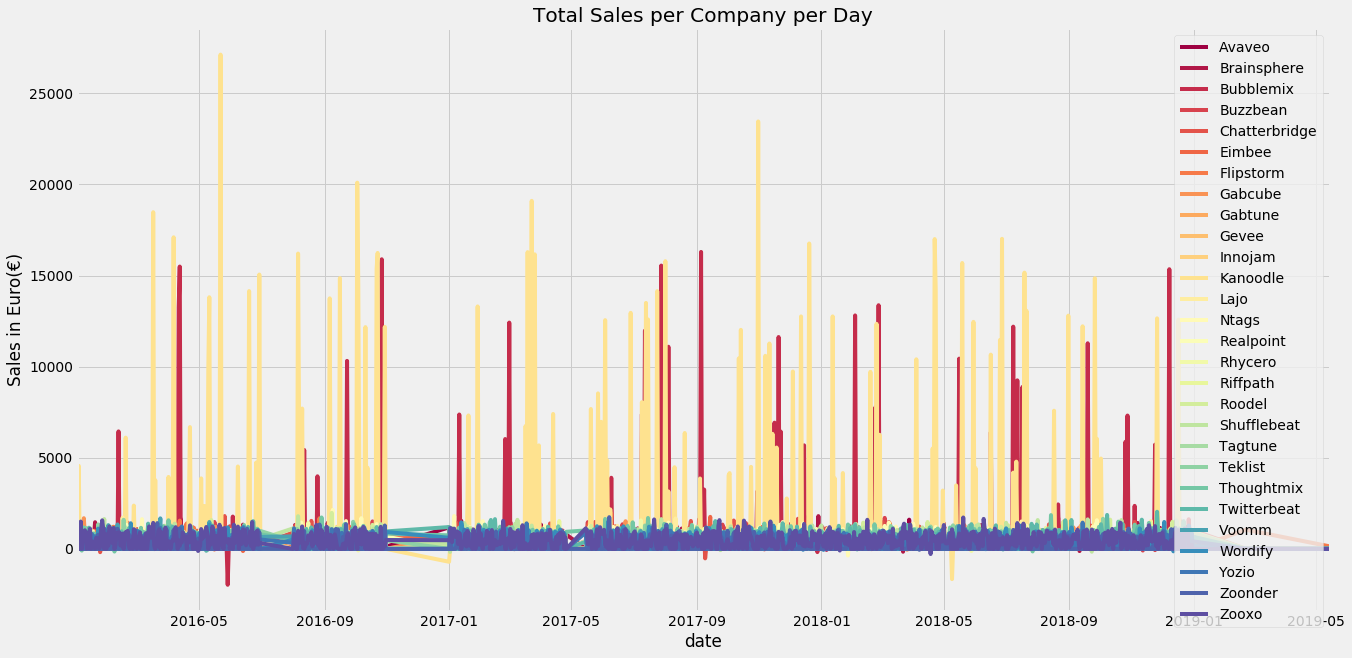

In [40]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral')
df_c_1.plot(x='date', y=['Avaveo', 'Brainsphere', 'Bubblemix', 'Buzzbean', 'Chatterbridge', 'Eimbee', 'Flipstorm', 'Gabcube', 'Gabtune',
 'Gevee', 'Innojam', 'Kanoodle', 'Lajo', 'Ntags', 'Realpoint', 'Rhycero', 'Riffpath', 'Roodel', 'Shufflebeat', 'Tagtune', 'Teklist',
 'Thoughtmix', 'Twitterbeat', 'Voomm', 'Wordify','Yozio', 'Zoonder', 'Zooxo',],figsize=(20,10), cmap = cmap)

plt.title('Total Sales per Company per Day')
plt.ylabel('Sales in Euro(€)')

plt.show()

---